### Import Libraries

In [223]:
import pandas as pd
import warnings
import logging
import math
import random
import os
import numpy as np
import seaborn as sns
from scipy import stats
from sklearn.svm import SVC
import multiprocessing as mp
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from IPython.display import display
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.svm import OneClassSVM
from sklearn.model_selection import learning_curve
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from imblearn.over_sampling import SMOTE
##from pgmpy.models import BayesianNetwork
from sklearn.ensemble import IsolationForest
#from pgmpy.inference import VariableElimination
from sklearn.neighbors import KNeighborsClassifier
from matplotlib.colors import ListedColormap
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report,accuracy_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.metrics import silhouette_score, confusion_matrix, classification_report
#from pgmpy.estimators import MaximumLikelihoodEstimator, HillClimbSearch, BicScore
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier

logger = logging.getLogger()
logger.setLevel(logging.CRITICAL)

### Load Dataset

In [224]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [225]:
# load base variant of fraud dataset
base_x = pd.read_csv('/content/drive/MyDrive/dataset/Base.csv')
base_x.head()

fraud_bool  income  name_email_similarity  prev_address_months_count  \
0           0     0.3               0.986506                         -1   
1           0     0.8               0.617426                         -1   
2           0     0.8               0.996707                          9   
3           0     0.6               0.475100                         11   
4           0     0.9               0.842307                         -1   

   current_address_months_count  customer_age  days_since_request  \
0                            25            40            0.006735   
1                            89            20            0.010095   
2                            14            40            0.012316   
3                            14            30            0.006991   
4                            29            40            5.742626   

   intended_balcon_amount payment_type  zip_count_4w  ...  has_other_cards  \
0              102.453711           AA          1059  ...                0   
1               -0.849551           AD          1658  ...                0   
2               -1.490386           AB          1095  ...                0   
3               -1.863101           AB          3483  ...                0   
4               47.152498           AA          2339  ...                0   

   proposed_credit_limit  foreign_request    source  \
0                 1500.0                0  INTERNET   
1                 1500.0                0  INTERNET   
2                  200.0                0  INTERNET   
3                  200.0                0  INTERNET   
4                  200.0                0  INTERNET   

   session_length_in_minutes device_os  keep_alive_session  \
0                  16.224843     linux                   1   
1                   3.363854     other                   1   
2                  22.730559   windows                   0   
3                  15.215816     linux                   1   
4                   3.743048     other                   0   

   device_distinct_emails_8w device_fraud_count  month  
0                          1                  0      0  
1                          1                  0      0  
2                          1                  0      0  
3                          1                  0      0  
4                          1                  0      0  

[5 rows x 32 columns]

In [328]:
base_x.shape

(1000000, 32)

In [331]:
base_x['fraud_bool'].value_counts()

fraud_bool
0    988971
1     11029
Name: count, dtype: int64

In [332]:
# select fraction of dataset for this task
base = base_x.sample(frac=0.1, random_state=1)
base.shape

(100000, 32)

In [227]:
feature_descriptions = {
    'income' : "Annual income of the applicant (in decile form). Ranges between [0.1, 0.9].",
    'name_email_similarity' : "Metric of similarity between email and applicant’s name. Higher values represent higher similarity. Ranges between [0, 1].",
    'prev_address_months_count' : "Number of months in previous registered address of the applicant, i.e. the applicant’s previous residence, if applicable. Ranges between [−1, 380] months (-1 is a missing value).",
    'current_address_months_count' : "Months in currently registered address of the applicant. Ranges between [−1, 429] months (-1 is a missing value).",
    'customer_age' : "Applicant’s age in years, rounded to the decade. Ranges between [10, 90] years.",
    'days_since_request' : "Number of days passed since application was done. Ranges between [0, 79] days.",
    'intended_balcon_amount' : "Initial transferred amount for application. Ranges between [−16, 114] (negatives are missing values).",
    'payment_type': "Credit payment plan type. 5 possible (annonymized) values.",
    'zip_count_4w' : "Number of applications within same zip code in last 4 weeks. Ranges between [1, 6830].",
    'velocity_6h' : "Velocity of total applications made in last 6 hours i.e., average number of applications per hour in the last 6 hours. Ranges between [−175, 16818].",
    'velocity_24h' : "Velocity of total applications made in last 24 hours i.e., average number of applications per hour in the last 24 hours. Ranges between [1297, 9586].",
    'velocity_4w' : "Velocity of total applications made in last 4 weeks, i.e., average number of applications per hour in the last 4 weeks. Ranges between [2825, 7020].",
    'bank_branch_count_8w' : "Number of total applications in the selected bank branch in last 8 weeks. Ranges between [0, 2404].",
    'date_of_birth_distinct_emails_4w' : "Number of emails for applicants with same date of birth in last 4 weeks. Ranges between [0, 39].",
    'employment_status' : "Employment status of the applicant. 7 possible (annonymized) values.",
    'credit_risk_score' : "Internal score of application risk. Ranges between [−191, 389].",
    'email_is_free' : "Domain of application email (either free or paid).",
    'housing_status' : "Current residential status for applicant. 7 possible (annonymized) values.",
    'phone_home_valid' : "Validity of provided home phone.",
    'phone_mobile_valid' : "Validity of provided mobile phone.",
    'bank_months_count' : "How old is previous account (if held) in months. Ranges between [−1, 32] months (-1 is a missing value).",
    'has_other_cards' : "If applicant has other cards from the same banking company.",
    'proposed_credit_limit' : "Applicant’s proposed credit limit. Ranges between [200, 2000].",
    'foreign_request' : "If origin country of request is different from bank’s country.",
    'source' : "Online source of application. Either browser (INTERNET) or app (TELEAPP).",
    'session_length_in_minutes' : "Length of user session in banking website in minutes. Ranges between [−1, 107] minutes (-1 is a missing value).",
    'device_os' : "Operative system of device that made request. Possible values are: Windows, macOS, Linux, X11, or other.",
    'keep_alive_session' : "User option on session logout.",
    'device_distinct_emails_8w' : "Number of distinct emails in banking website from the used device in last 8 weeks. Ranges between [−1, 2] emails (-1 is a missing value).",
    'device_fraud_count' : "Number of fraudulent applications with used device. Ranges between [0, 1].",
    'month' : "Month where the application was made. Ranges between [0, 7].",
    'fraud_bool' : "If the application is fraudulent or not.1 indiates fraud and0 indicates legit"
}

In [355]:
months = base['month'].unique()
months

array([2, 6, 3, 4, 7, 5, 0, 1])

In [354]:
months = base['month'].unique()
for month in months:
  print(f'Month {month}: {len(base[base["month"]==month])}')

Month 2: 13693
Month 6: 10683
Month 3: 15028
Month 4: 12723
Month 7: 9766
Month 5: 11938
Month 0: 13284
Month 1: 12885


In [356]:
base[base['month']==2][['month','velocity_4w']]

month  velocity_4w
276826      2  5339.732229
372778      2  5215.869880
309734      2  5486.506767
316699      2  5193.981626
339502      2  5150.761292
...       ...          ...
343146      2  5107.271926
278735      2  5042.447798
348129      2  5111.775413
323843      2  5305.660497
295097      2  5635.455161

[13693 rows x 2 columns]

In [228]:
# split numerical and categorical features
num_features = base.select_dtypes(include='number').columns.tolist()

thresh = 25

cont_feats = [feat for feat in num_features if base[feat].nunique() >= thresh]
disc_feats = [feat for feat in num_features if base[feat].nunique() < thresh]

cat_feats = base.select_dtypes(exclude='number').columns.tolist()
target_feat = disc_feats[0]
disc_feats.remove(target_feat)

cont_feats.append(disc_feats[0])
disc_feats.remove(disc_feats[0])

print(f'Features: {base.shape[1]}\n\n\
Num features: {len(num_features)}\n\
{num_features}\n\n\
Continuous: {len(cont_feats)}\n\
{cont_feats}\n\n\
Discrete: {len(disc_feats)}\n\
{disc_feats}\n\n\
Categorical: {len(cat_feats)}\n\
{cat_feats}')

print(f'\n\nTarget feature: {target_feat}')

Features: 32

Num features: 27
['fraud_bool', 'income', 'name_email_similarity', 'prev_address_months_count', 'current_address_months_count', 'customer_age', 'days_since_request', 'intended_balcon_amount', 'zip_count_4w', 'velocity_6h', 'velocity_24h', 'velocity_4w', 'bank_branch_count_8w', 'date_of_birth_distinct_emails_4w', 'credit_risk_score', 'email_is_free', 'phone_home_valid', 'phone_mobile_valid', 'bank_months_count', 'has_other_cards', 'proposed_credit_limit', 'foreign_request', 'session_length_in_minutes', 'keep_alive_session', 'device_distinct_emails_8w', 'device_fraud_count', 'month']

Continuous: 15
['name_email_similarity', 'prev_address_months_count', 'current_address_months_count', 'days_since_request', 'intended_balcon_amount', 'zip_count_4w', 'velocity_6h', 'velocity_24h', 'velocity_4w', 'bank_branch_count_8w', 'date_of_birth_distinct_emails_4w', 'credit_risk_score', 'bank_months_count', 'session_length_in_minutes', 'income']

Discrete: 11
['customer_age', 'email_is_fr

### Data Cleaning and Preparation

In [229]:
# Encoding Categorical Variables
def encode_columns(df, categorical):
    df_encoded = df.copy()  # Create a copy of the DataFrame to work on
    le = LabelEncoder()
    for col in categorical:
        df_encoded[col] = le.fit_transform(df_encoded[col])  # Convert to string to handle any type of data
    return df_encoded

# Encode the categorical and target columns
base_encoded = encode_columns(base, cat_feats)

In [231]:
# Missing values are denoted by -1
base_clean = base_encoded[~base_encoded.isin([-1]).any(axis=1)]
base_clean = base_clean.replace([np.inf, -np.inf], np.nan).dropna()
base_clean.shape

(19596, 32)

In [330]:
base_clean['fraud_bool'].value_counts()

fraud_bool
0    19540
1       56
Name: count, dtype: int64

In [377]:
def perform_smote(base_clean):
  # split input features and target
  X = base_clean.drop(target_feat, axis=1)
  y = base_clean[target_feat]

  # Calculate the number of fraud accounts after oversampling
  n_legit = len(base_clean[base_clean['fraud_bool']==0])
  n_fraud = 0.80 * n_legit

  # Using SMOTE to oversample fraud accounts
  smote = SMOTE(sampling_strategy={1: int(n_fraud)})
  X_smote, y_smote = smote.fit_resample(X, y)

  # Combine the resampled features and labels into a new DataFrame
  base_smote = pd.concat([X_smote, y_smote], axis=1)
  print(f'Shape of the resampled data: {base_smote.shape}')
  print(base_smote['fraud_bool'].value_counts())

  return base_smote

base_smote = perform_smote(base_clean)

Shape of the resampled data: (35172, 32)
fraud_bool
0    19540
1    15632
Name: count, dtype: int64


In [378]:
# split original dataset input features and target
X = base_clean.drop(target_feat, axis=1)
y = base_clean[target_feat]

# split dataset into train and test
train_input, test_input, train_output, test_output = train_test_split(X, y , test_size = 0.2)

# display the shape of train and test dataset
print(train_input.shape)
print(test_input.shape)
print(train_output.shape)
print(test_output.shape)

(15676, 31)
(3920, 31)
(15676,)
(3920,)


## Exploratory Data Analysis

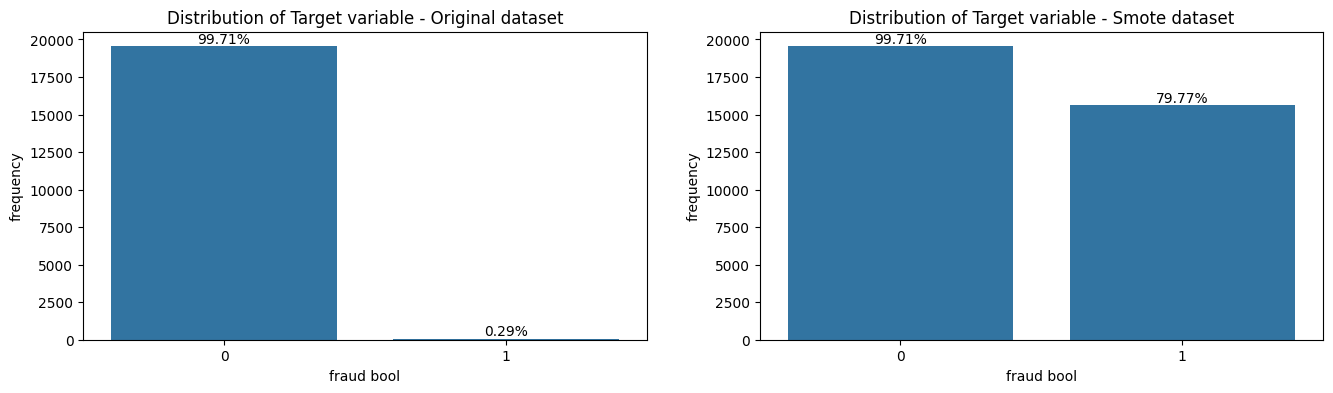

In [172]:
figx,ax = plt.subplots(1,2, figsize=(16,4))
ax=ax.flatten()
# plot frequency of dependent variable
total_cnt = len(base_clean)
ax[0] = sns.countplot(x='fraud_bool', data=base_clean, ax=ax[0])

for p in ax[0].patches:
    ax[0].annotate(f'{(p.get_height()/total_cnt)*100:.2f}%',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='bottom', xytext=(0,0), textcoords='offset points')

# Add titles and labels
ax[0].set_title('Distribution of Target variable - Original dataset')
ax[0].set_xlabel('fraud bool')
ax[0].set_ylabel('frequency')

ax[1] = sns.countplot(x='fraud_bool', data=base_smote, ax=ax[1])

for p in ax[1].patches:
    ax[1].annotate(f'{(p.get_height()/total_cnt)*100:.2f}%',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='bottom', xytext=(0,0), textcoords='offset points')

# Add titles and labels
ax[1].set_title('Distribution of Target variable - Smote dataset')
ax[1].set_xlabel('fraud bool')
ax[1].set_ylabel('frequency')

# Show the plot
plt.show();


In [379]:
# method to find descriptive stats and correlation
def eda_cont_stats(feat, base):
    feature_stats = []
    corr = ['velocity_4w', 'proposed_credit_limit', 'month']
    for col in feat:
        missing_values = len(base[base[col] == -1])
        mean = base[col].mean()
        std = base[col].std()
        minimum = base[col].min()
        maximum = base[col].max()
        median = base[col].median()
        correlation = base_encoded.corr()['fraud_bool'][col]

        feature_stats.append({
            'Feature': col,
            'Missing Values': missing_values,
            'Mean': mean,
            'Standard Deviation': std,
            'Minimum': minimum,
            'Maximum': maximum,
            'Median': median,
            'Correlation': correlation
        })

    return feature_stats

# Create a DataFrame from the list of dictionaries
feature_stats = eda_cont_stats(cont_feats, base_smote)
base_stats = pd.DataFrame(feature_stats)
base_stats

Feature  Missing Values         Mean  \
0              name_email_similarity               0     0.401071   
1          prev_address_months_count               0    67.408166   
2       current_address_months_count               0    27.947344   
3                 days_since_request               0     2.797680   
4             intended_balcon_amount               0    10.004023   
5                       zip_count_4w               0  1475.642471   
6                        velocity_6h               0  5153.267196   
7                       velocity_24h               0  4817.544075   
8                        velocity_4w               0  4846.109582   
9               bank_branch_count_8w               0   165.369243   
10  date_of_birth_distinct_emails_4w               0     9.553565   
11                 credit_risk_score               0   139.286023   
12                 bank_months_count               0    16.623450   
13         session_length_in_minutes               0     9.483971   
14                            income               0     0.646590   

    Standard Deviation      Minimum       Maximum       Median  Correlation  
0             0.274671     0.000159      0.999999     0.362047    -0.034323  
1            63.374232     6.000000    371.000000    46.000000    -0.028807  
2            46.155145     0.000000    416.000000    10.000000     0.032112  
3             8.593586     0.000003     76.296635     0.015340     0.007688  
4            18.830497   -10.410875    111.396564    -0.645812    -0.024422  
5           906.702822     3.000000   6314.000000  1268.000000     0.011383  
6          3080.823756  -106.978297  16356.364000  4790.071904    -0.018423  
7          1478.206365  1423.654460   9409.114804  4789.701008    -0.007897  
8           993.476827  2989.524700   6988.564717  4951.407650    -0.013456  
9           374.115108     0.000000   2287.000000    14.000000    -0.014060  
10            5.089520     0.000000     37.000000     9.000000    -0.045683  
11           63.722895  -148.000000    369.000000   134.000000     0.070045  
12           10.793637     1.000000     32.000000    19.000000     0.000837  
13            9.379658     0.011926     78.772814     6.591022     0.004580  
14            0.255541     0.100000      0.900000     0.700000     0.046389

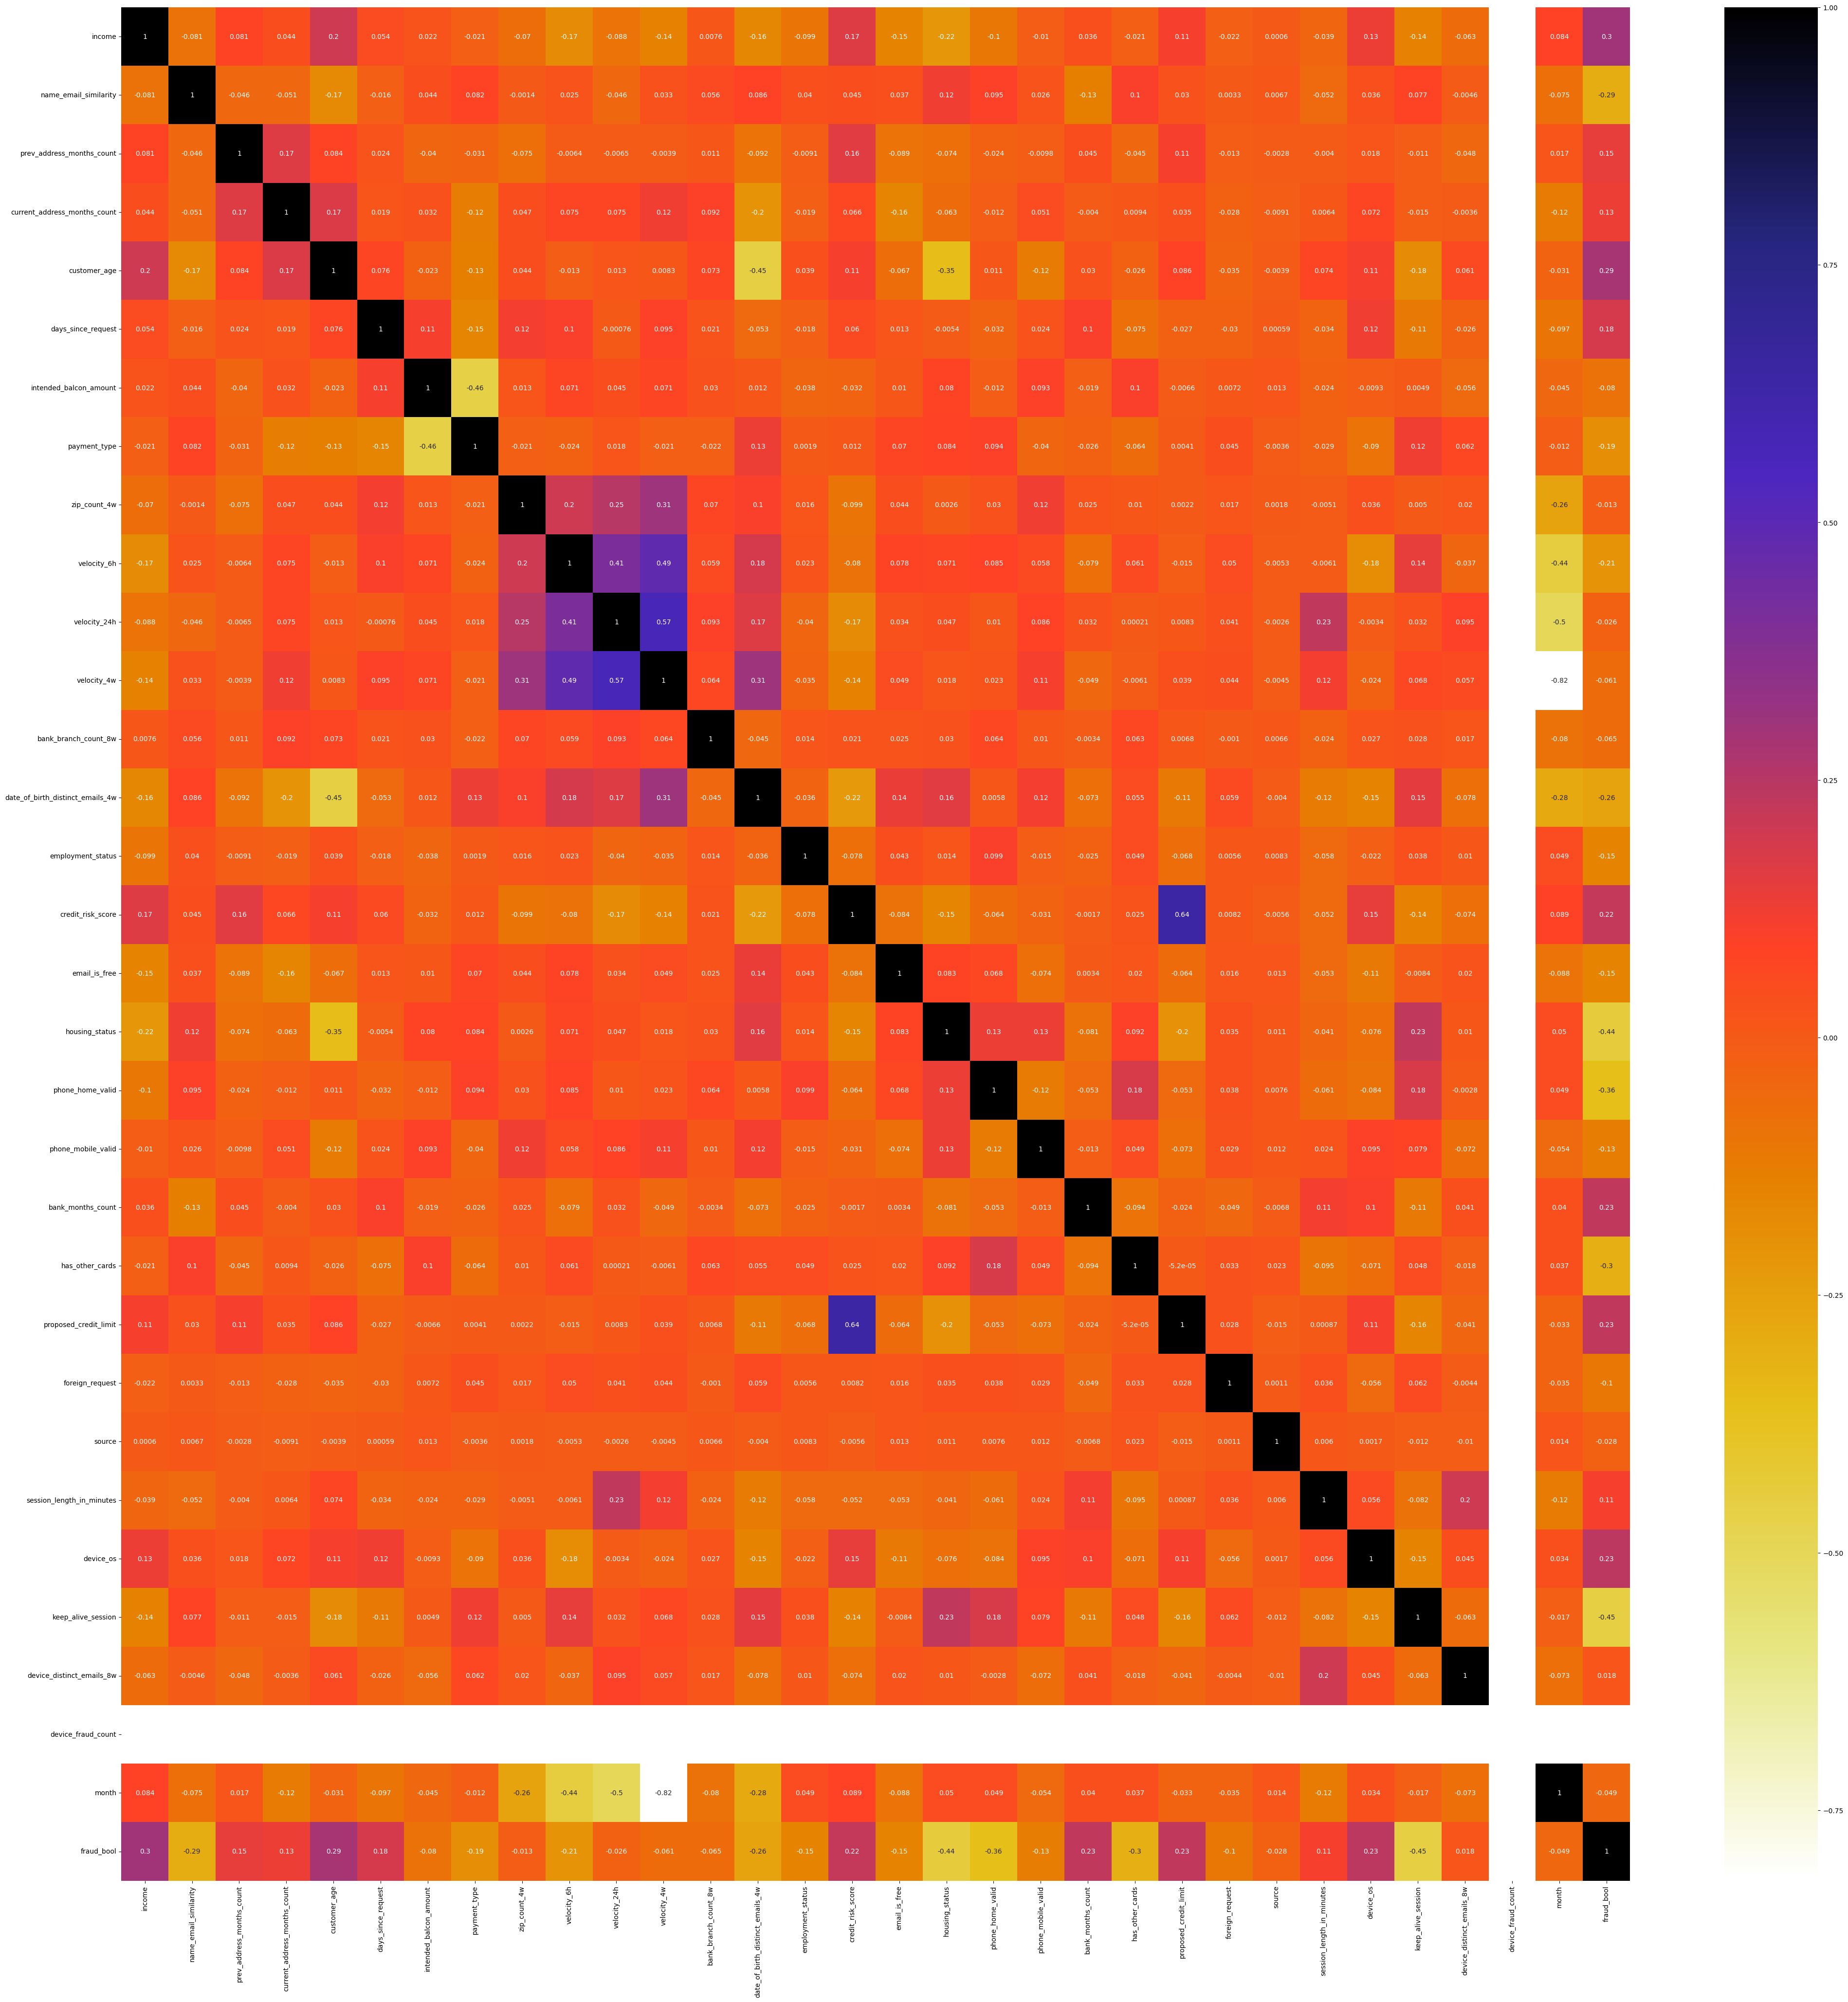

In [380]:
# correlation heat map
plt.figure(figsize=(50,50))
cor = base_smote.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.CMRmap_r)
plt.show()

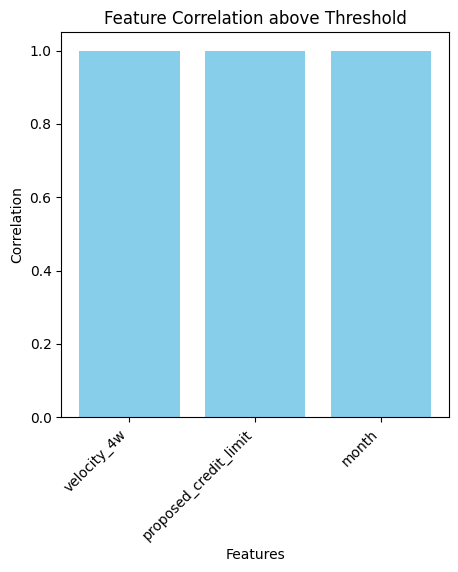

Correlated Features: ['velocity_4w', 'proposed_credit_limit', 'month']


In [381]:
def correlation(df, threshold):
    col_corr = set()  # Set to hold correlated column names
    corr_matrix = df.corr()

    # Loop through the correlation matrix
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if abs(corr_matrix.iloc[i, j]) > threshold:
                colname = corr_matrix.columns[i]
                col_corr.add(colname)

    col_corr = list(col_corr)
    if col_corr:
        plt.figure(figsize=(5, 5))

        # Extract correlation values for plotting
        corr_values = [np.max(np.abs(corr_matrix.loc[col, :])) for col in col_corr]

        plt.bar(col_corr, corr_values, color='skyblue')
        plt.title('Feature Correlation above Threshold')
        plt.xlabel('Features')
        plt.ylabel('Correlation')
        plt.xticks(rotation=45, ha='right')
        plt.show()
    else:
        print("No features found with correlation above the threshold.")

    return col_corr

# Usage example
corr_features = correlation(base_smote, 0.5)
print("Correlated Features:", corr_features)




1.   Proposed credit limit is highly correlated with credit score
2. Month represents the volume of applications that may be depict seasonal trends. This is correlated with the velocity of applications for 6h, 2h or 4w
3. Device fraud count does not have any influence on any features as all the samples have the value 0





In [363]:
def plot_correlation(features):
  warnings.filterwarnings('ignore')
  plt.figure(figsize=(18, 6))
  feat1, feat2 = features
  sns.barplot(x=feat1, y=feat2, data=base_clean, palette='viridis',orient='h')
  plt.xlabel(f'{feat1}')
  plt.ylabel(f'{feat2}')
  plt.title(f'Bar Plot of {feat1} vs. {feat2}')


In [ ]:
def plot_correlation_scatter(features):

    feat1, feat2 = features
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x=feat1, y=feat2, data=base_encoded, alpha=0.5)
    plt.xlabel(feat1)
    plt.ylabel(feat2)
    plt.title(f'Scatter Plot of {feat1} vs. {feat2}')
    plt.show()



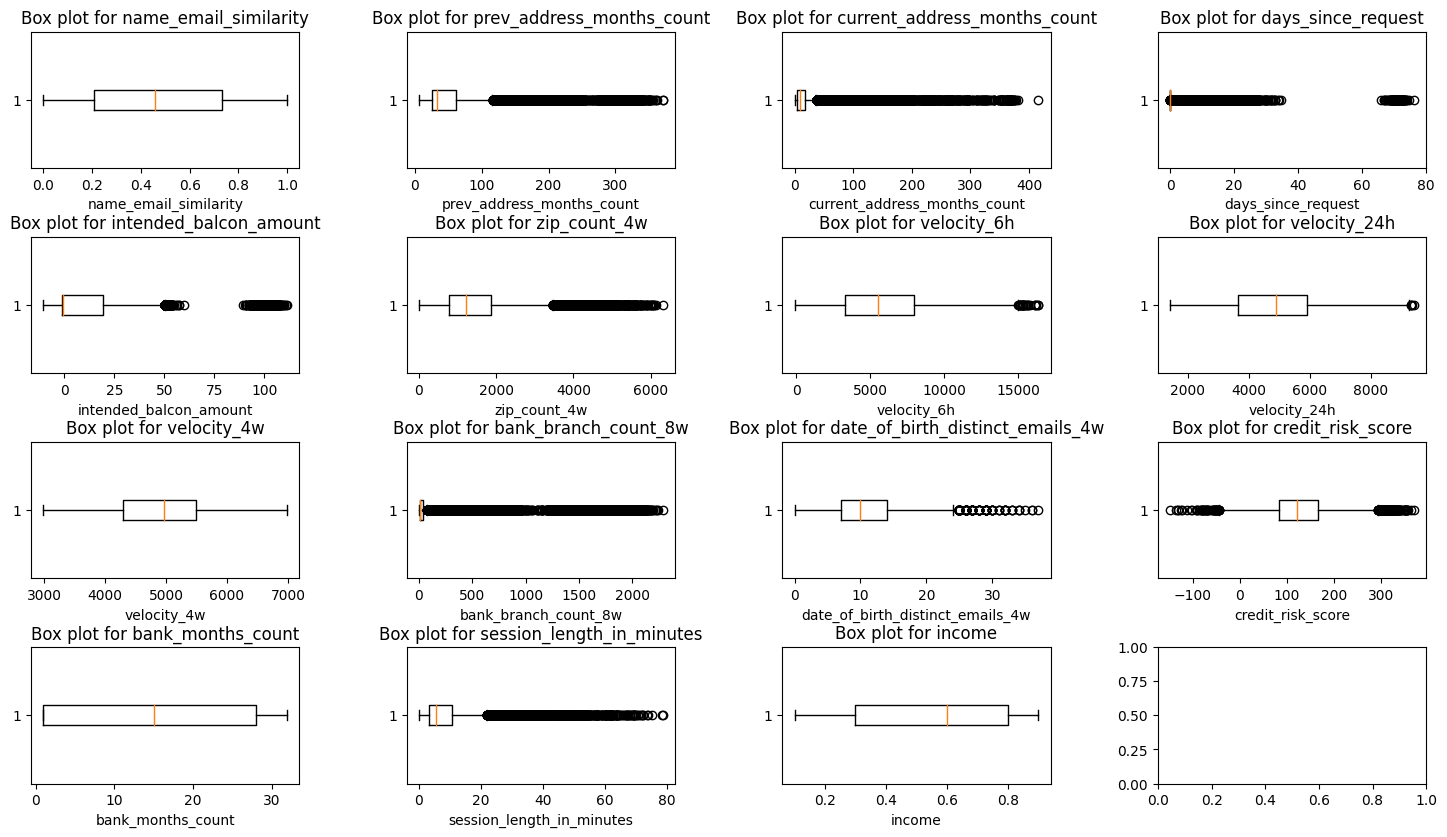

In [335]:
# box plot to detect outliers
fig, ax = plt.subplots(4, 4, figsize=(18, 8))
plt.subplots_adjust(top = 0.99, bottom=0.05, hspace=0.5, wspace=0.4)
ax = ax.flatten()
for i,col in enumerate(cont_feats):
    ax[i].set_title(f'Box plot for {col}')
    ax[i].set_xlabel(col)
    ax[i].boxplot(base_clean[col], vert=False)

plt.show()

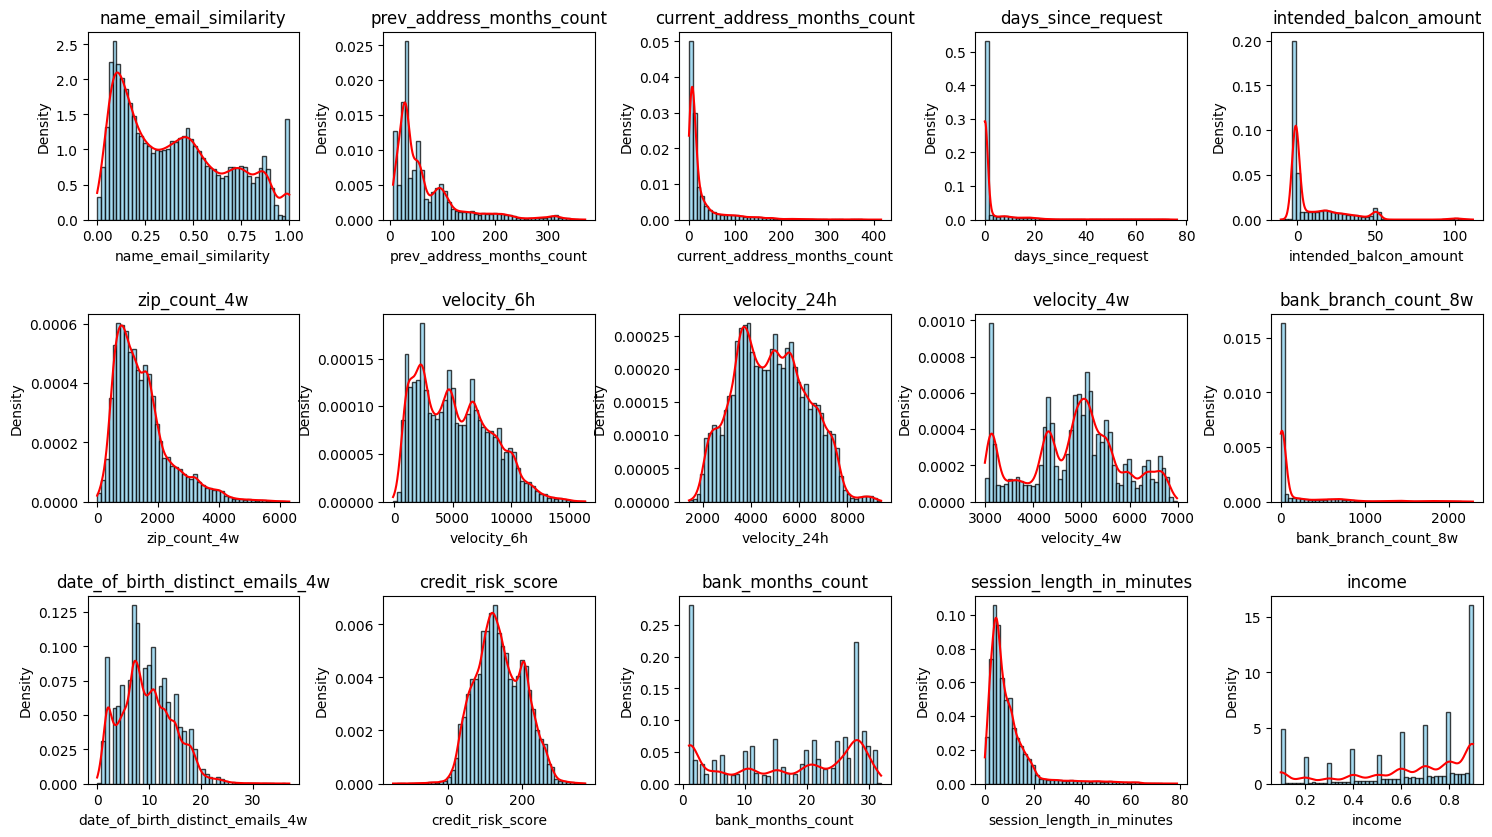

In [179]:
# create histogram with KDE plot for all teh numerical features
fig, ax = plt.subplots(3, 5, figsize=(18, 8))
plt.subplots_adjust(top = 0.99, bottom=0.05, hspace=0.5, wspace=0.4)
ax = ax.flatten()
for i,col in enumerate(cont_feats):
    #print(f'{base_smote[col].skew()}~{col}')
    # Check if the column is numeric before applying KDE
    if base_smote[col].dtype in [np.int64, np.float64]:
        kde = stats.gaussian_kde(base_smote[col])
        x = np.linspace(base_smote[col].min(), base_smote[col].max(), 1000)
        ax[i].plot(x, kde(x), color='red')
        ax[i].hist(base_smote[col], bins=50, density=True, alpha=0.75, color='skyblue', edgecolor='black')
        ax[i].set_title(f'{col}')
        ax[i].set_xlabel(col)
        ax[i].set_ylabel('Density')
    else:
        print(f"Skipping non-numeric column: {col}") # Inform the user about skipped columns

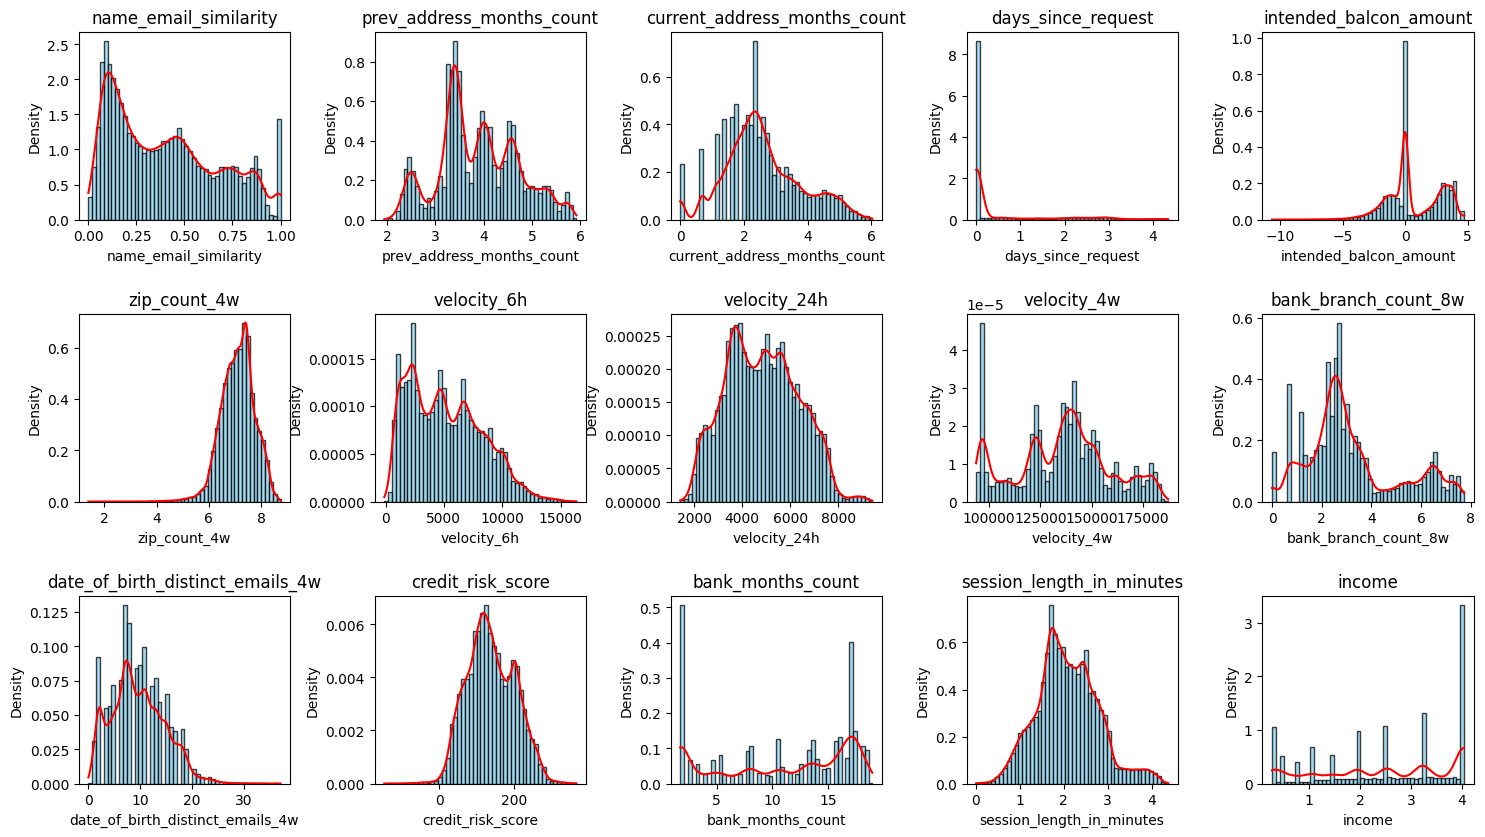

In [180]:
def normalizeDistributions(feats):
  fig, ax = plt.subplots(3, 5, figsize=(18, 8))
  plt.subplots_adjust(top = 0.99, bottom=0.05, hspace=0.5, wspace=0.4)
  ax = ax.flatten()
  for i,col in enumerate(feats):
      # Check if the column is numeric before applying KDE
      if base_smote[col].dtype in [np.int64, np.float64]:
        # Normalize the column, handling potential issues
          x_col = base_smote[col].copy() # Create a copy to avoid modifying the original
          # Log Transformation (after shifting if needed)
          constant = abs(x_col.min()) + 1

          # Check for negative skewness

          if x_col.skew() > 1:
              x_col = np.log1p(x_col)

          elif x_col.skew() < 0:
              x_col, lambda_ = stats.boxcox(x_col+constant)

          #print(f'{x_col.skew()}~{col}')
          x_col = np.nan_to_num(x_col)

          kde = stats.gaussian_kde(x_col)
          x = np.linspace(x_col.min(), x_col.max(), 1000)
          ax[i].plot(x, kde(x), color='red')
          ax[i].hist(x_col, bins=50, density=True, alpha=0.75, color='skyblue', edgecolor='black')
          ax[i].set_title(f'{col}')
          ax[i].set_xlabel(col)
          ax[i].set_ylabel('Density')
          #base_smote[col] = x_col
      else:
          print(f"Skipping non-numeric column: {col}") # Inform the user about skipped columns

normalizeDistributions(cont_feats)

In [392]:
corr_feats = ['month','velocity_4w']

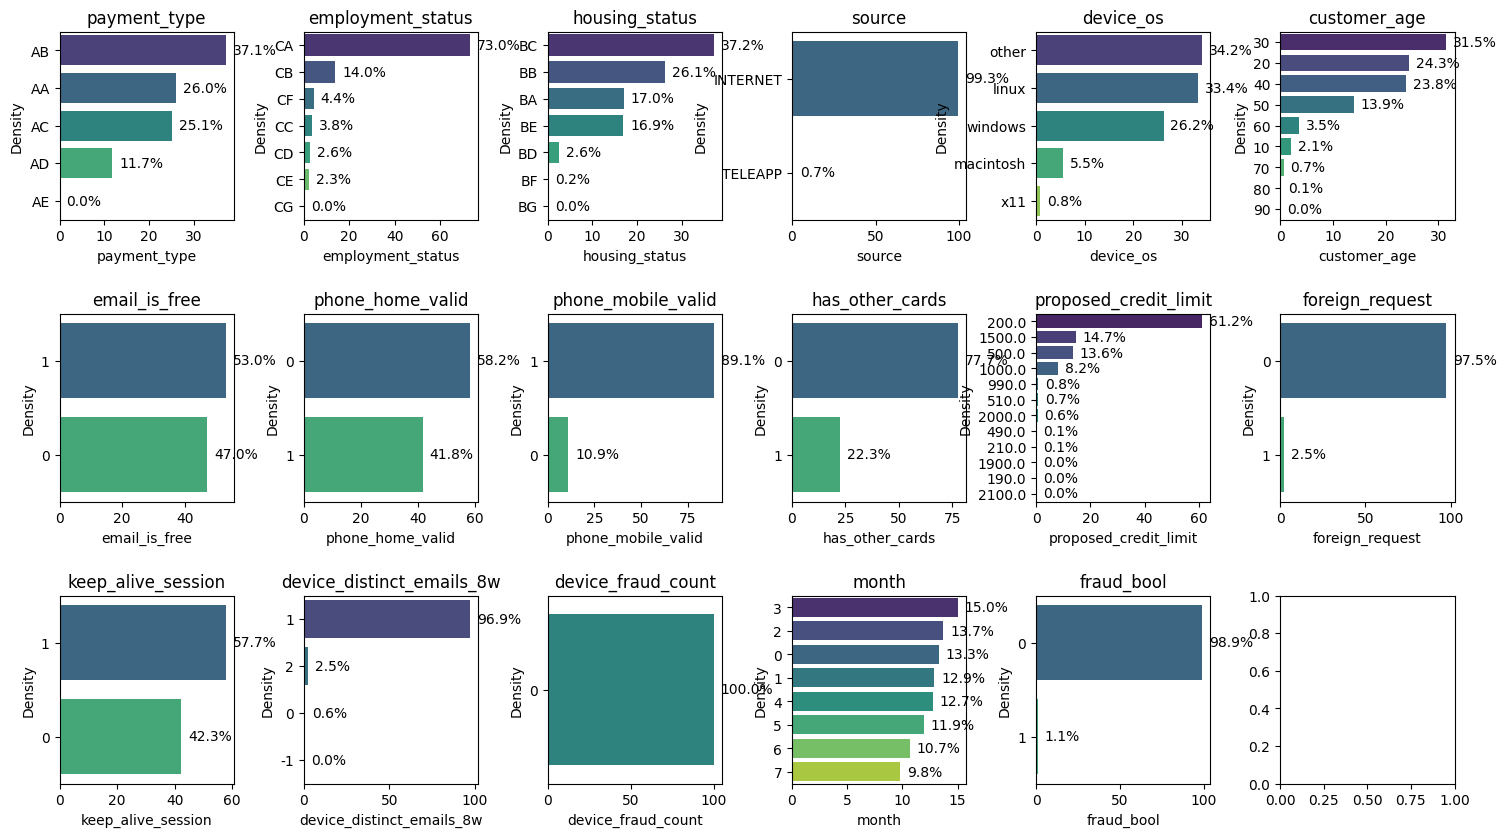

In [397]:
# create histogram with KDE plot for all teh numerical features
def eda_cat_feats(feats):
  warnings.filterwarnings('ignore')
  fig, ax = plt.subplots(3, 6, figsize=(18, 8))
  plt.subplots_adjust(top = 0.99, bottom=0.05, hspace=0.5, wspace=0.4)
  ax = ax.flatten()
  for i,col in enumerate(feats):

      # Plotting horizontal bar plots on the first axis
      value_counts = base[col].value_counts()
      percent_total = value_counts / sum(value_counts) * 100
      bars = sns.barplot(x=percent_total.values, y=percent_total.index, ax=ax[i], palette='viridis', orient='h',order=percent_total.index)
      # Annotating the bars with percentage values
      for bar, perc in zip(bars.patches, percent_total.values):
          ax[i].annotate(f'{perc:.1f}%',
                        xy=(bar.get_width(), bar.get_y() + bar.get_height() / 2),
                        xytext=(5, 0),  # 5 points horizontal offset
                        textcoords='offset points',
                        ha='left', va='center')

      ax[i].set_title(f'{col}')
      ax[i].set_xlabel(col)
      ax[i].set_ylabel('Density')

eda_cat_feats(cat_feats+disc_feats+[target_feat])

In [185]:
# calculate proportion for each colunmn
def calculateProportion(df, column):
    percent_of_total = df.groupby([column, target_feat]).size().unstack()
    for i in range(len(percent_of_total)):
        percent_of_total.iloc[i,:] = percent_of_total.iloc[i,:]/sum(percent_of_total.iloc[i,:])
    return percent_of_total

def plot_proportion(df):
  corr = ['velocity_4w', 'proposed_credit_limit', 'month']
  fig, ax = plt.subplots(15, 1, figsize=(18, 48))
  ax = ax.flatten()
  cmp = ListedColormap(['royalblue', 'darkturquoise'])
  for i,col in enumerate(cat_feats+disc_feats):
      if col in corr:
          continue
      proportion = calculateProportion(df, col)
      bars = proportion.plot(kind='bar', ax=ax[i], stacked=True, colormap=cmp, legend=False, ylabel='Proportion', sharey=True)
      for bar_container in bars.containers:
          for bar in bar_container:
              height = bar.get_height()
              ax[i].annotate(f'{height:.1%}',
                            xy=(bar.get_x() + bar.get_width() / 2, bar.get_y() + height / 2),
                            xytext=(0, 0),  # No offset
                            textcoords="offset points",
                            ha='center', va='center', fontsize=10, color='black')
      ax[i].set_title(f'Proportion of {col}')
      ax[i].legend(loc=(0.7, 0.9), fontsize=8, ncol=2)
      ax[i].set_ylim([0.2, 1.12])
      rotation = 90 if i==7 or i==3 else 0
      ax[i].set_xticklabels(ax[i].get_xticklabels(), rotation=rotation)

  plt.suptitle('Fraud_bool vs Categorical features', fontsize=22)
  #plt.tight_layout()
  plt.tight_layout(rect=[0, 0, 1, 0.95])
  plt.show()

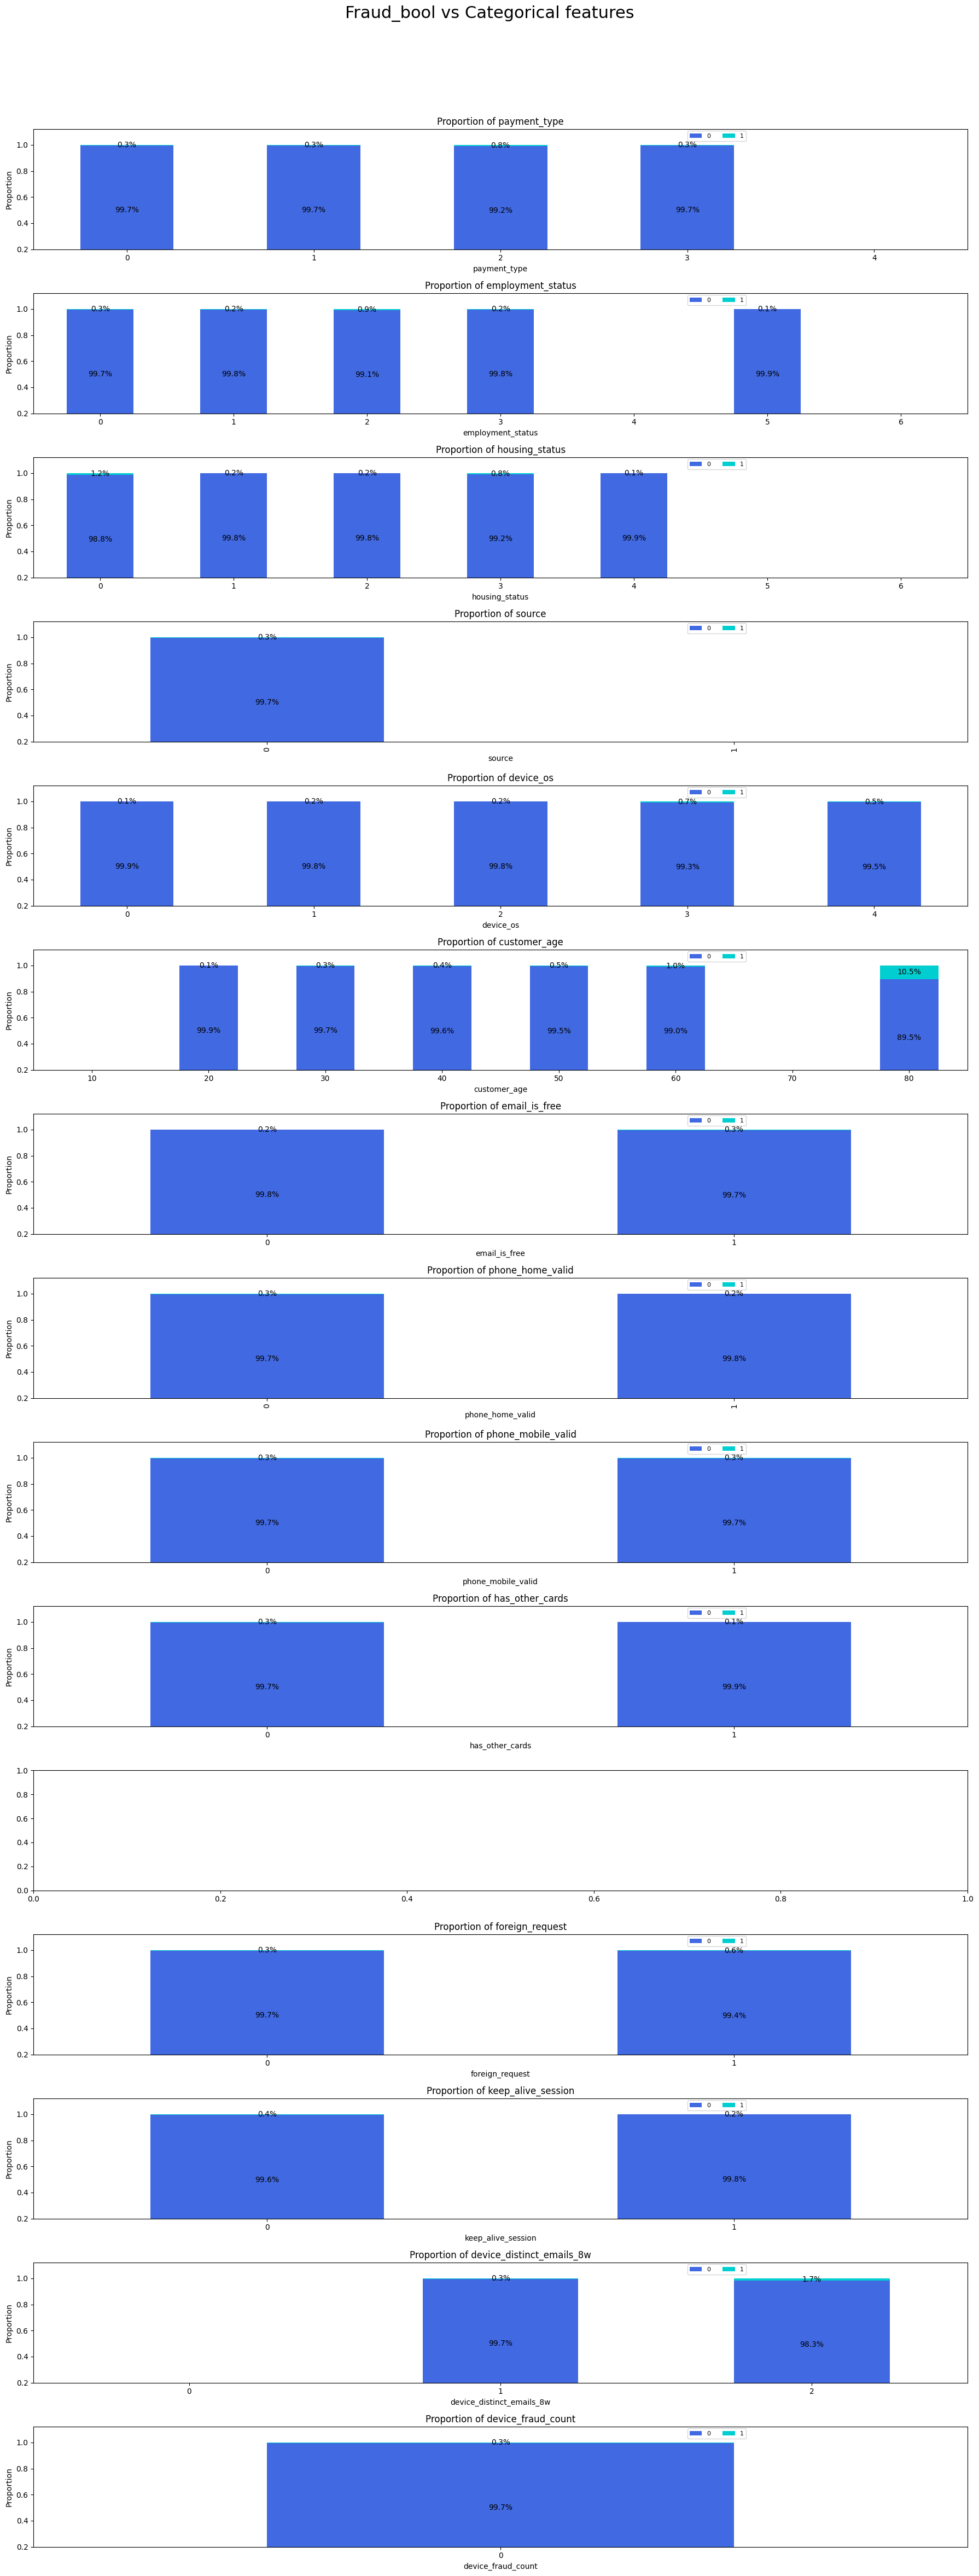

In [186]:
plot_proportion(base_clean)

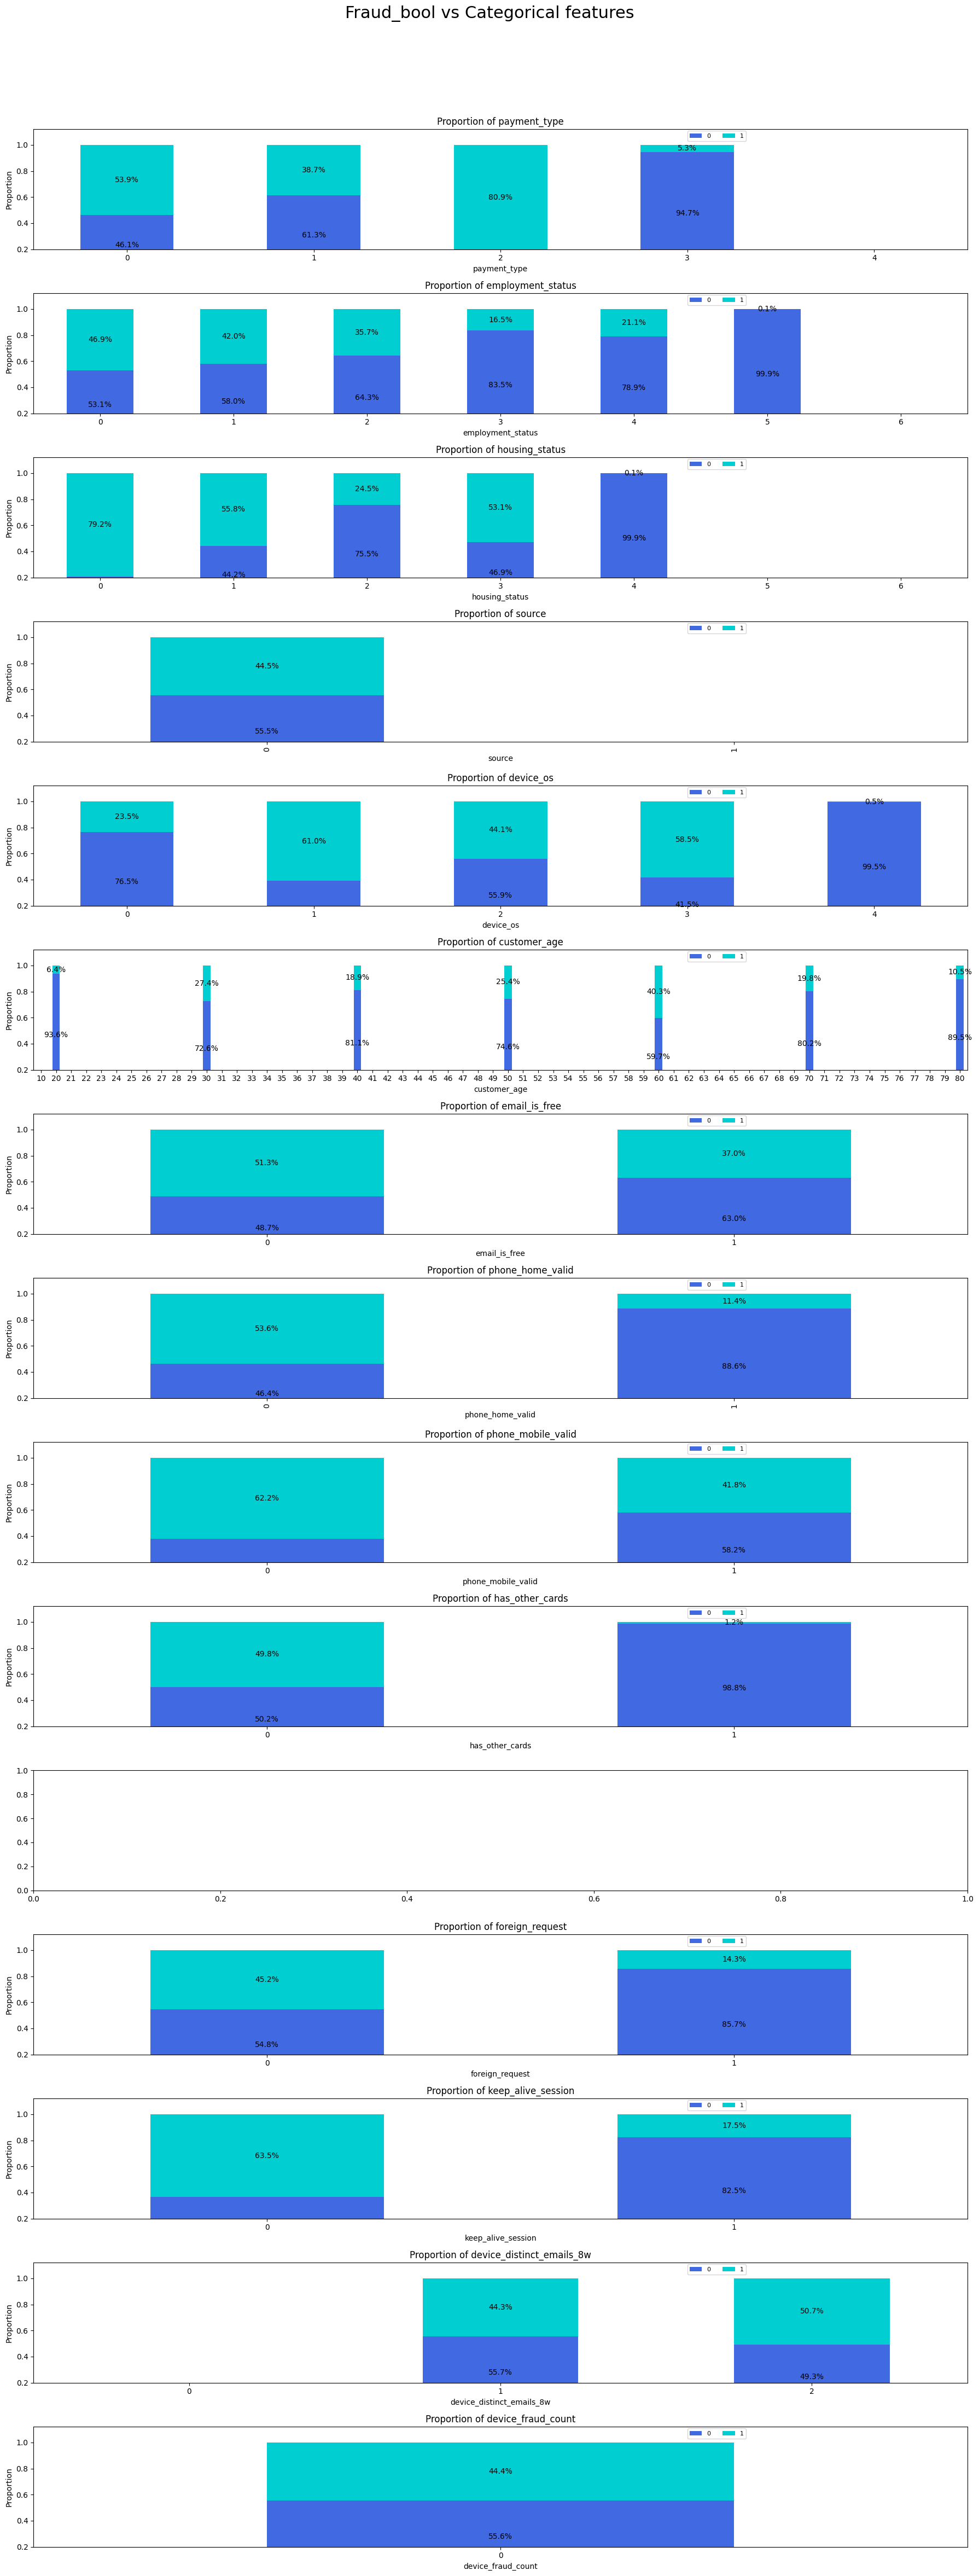

In [187]:
plot_proportion(base_smote)

## Feature Engineering

In [304]:
# oversample fraudlent data to balance
base_smote = perform_smote(base_clean)

Shape of the resampled data: (35172, 32)
fraud_bool
0    19540
1    15632
Name: count, dtype: int64


In [305]:
# Normalize skewed distribution containing outliers
for col in cont_feats:
  # Check if the column is numeric before applying KDE
  if base_smote[col].dtype in [np.int64, np.float64]:
    # Normalize the column, handling potential issues
      x_col = base_smote[col].copy() # Create a copy to avoid modifying the original
      # Log Transformation (after shifting if needed)
      constant = abs(x_col.min()) + 1

      # Check for positive and negative skewness
      if x_col.skew() > 1:
          x_col = np.log1p(x_col)
      elif x_col.skew() < 0:
          x_col, lambda_ = stats.boxcox(x_col+constant)

      #print(f'{x_col.skew()}~{col}')
      x_col = np.nan_to_num(x_col)
      base_smote[col] = x_col

In [306]:
# drop high correlation and redundant features
for col in corr_features:
    base_smote.drop(col, axis=1, inplace=True)
base_smote.head()

income  name_email_similarity  prev_address_months_count  \
0  1.955655               0.461974                   3.433987   
1  4.087072               0.388111                   3.465736   
2  0.736432               0.123415                   2.302585   
3  0.476717               0.069168                   3.091042   
4  0.273252               0.869321                   3.218876   

   current_address_months_count  customer_age  days_since_request  \
0                      2.197225            30            0.006307   
1                      1.098612            50            0.010426   
2                      4.043051            40            0.030764   
3                      3.688879            30            0.000881   
4                      2.833213            20            0.009872   

   intended_balcon_amount  payment_type  zip_count_4w  velocity_6h  ...  \
0               -2.486892             1      7.679251  1108.075600  ...   
1               -1.699460             1      7.892452  3849.725772  ...   
2                0.000000             1      6.535241  7503.932076  ...   
3                2.491138             0      7.000334  4052.377030  ...   
4                3.738105             1      7.239933  1586.570545  ...   

   bank_months_count  has_other_cards  foreign_request  source  \
0           1.723935                0                0       0   
1          12.158826                1                0       0   
2          12.647698                0                0       0   
3           4.494320                0                0       0   
4          10.145108                0                0       0   

   session_length_in_minutes  device_os  keep_alive_session  \
0                   1.872225          0                   0   
1                   1.437341          3                   1   
2                   0.575046          3                   1   
3                   2.922586          3                   1   
4                   2.166959          2                   0   

   device_distinct_emails_8w  device_fraud_count  fraud_bool  
0                          1                   0           0  
1                          1                   0           0  
2                          1                   0           0  
3                          1                   0           0  
4                          1                   0           0  

[5 rows x 29 columns]

In [307]:
# split dataset into train and test
X = base_smote.drop(target_feat, axis=1)
y = base_smote[target_feat]

Xtrain, Xtest, ytrain, ytest = train_test_split(X, y , test_size = 0.2)
print(Xtrain.shape)
print(Xtest.shape)
print(ytrain.shape)
print(ytest.shape)

(28137, 28)
(7035, 28)
(28137,)
(7035,)


## Classification Algorithms

In [ ]:
test_acc_raw = []
test_acc_transformed = []

#### **Ensemnble Learning**

In [308]:
voting_clf = VotingClassifier(
      estimators=[
          ('lr', LogisticRegression(random_state=42)),
          ('rf', RandomForestClassifier(random_state=42)),
          ('svc', SVC(random_state=42))
      ]
  )

def KfoldCrossValidation(X, y, test_X, test_y, n_splits):

  # Standardize the features
  scaler = StandardScaler()
  X_scaled = scaler.fit_transform(X)
  X_test_scaled = scaler.transform(test_X)

  # Apply PCA for dimensionality reduction (for visualization purposes)
  pca = PCA(n_components=2)
  X_pca_km = pca.fit_transform(X_scaled)
  X_test_pca_km = pca.transform(X_test_scaled)

  # Define the number of splits for K-Fold
  kf = KFold(n_splits=n_splits, shuffle=True, random_state=4)

  # Define the scoring metrics
  scoring =  scoring = ['accuracy', 'precision', 'recall', 'f1']

  # Perform K-Fold cross-validation
  cv_results = cross_validate(voting_clf, X_pca_km, y, cv=kf, scoring=scoring)

  # Display the mean scores across all folds
  print(f"Mean Accuracy: {np.mean(cv_results['test_accuracy']):.2f}")
  print(f"Mean Precision: {np.mean(cv_results['test_precision']):.2f}")
  print(f"Mean Recall: {np.mean(cv_results['test_recall']):.2f}")
  print(f"Mean F1 Score: {np.mean(cv_results['test_f1']):.2f}")

  return X_pca_km, X_test_pca_km


def evaluate_test(X, y, X_pca_test_km, test_y):


  #fit the model on train and predict
  voting_clf.fit(X, y)
  y_pred = voting_clf.predict(X_pca_test_km)

  print("Final Evaluation on Test Data")
  print(f"Test Accuracy: {accuracy_score(test_y, y_pred):.2f}")
  print("Classification Report:\n", classification_report(test_y, y_pred))

def plot_learning_curve(X, y):
  # Step 2: Use learning_curve to get training and validation scores
  train_sizes, train_scores, validation_scores = learning_curve(
      voting_clf, X, y, cv=5, scoring='accuracy', n_jobs=-1,
      train_sizes=np.linspace(0.1, 1.0, 10), random_state=42
  )

  # Step 3: Calculate the mean and standard deviation of the scores
  train_scores_mean = np.mean(train_scores, axis=1)
  validation_scores_mean = np.mean(validation_scores, axis=1)
  train_scores_std = np.std(train_scores, axis=1)
  validation_scores_std = np.std(validation_scores, axis=1)

  # Step 4: Plot the learning curves
  plt.figure(figsize=(6, 5))
  plt.plot(train_sizes, train_scores_mean, label='Training Accuracy', color='blue', marker='o')
  plt.plot(train_sizes, validation_scores_mean, label='Validation Accuracy', color='red', marker='o')

  # Step 5: Plot the shaded area for standard deviation
  plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                  train_scores_mean + train_scores_std, color='blue', alpha=0.2)
  plt.fill_between(train_sizes, validation_scores_mean - validation_scores_std,
                  validation_scores_mean + validation_scores_std, color='red', alpha=0.2)

  # Step 6: Add labels, title, and legend
  plt.title('Learning Curves (Voting Classifier)')
  plt.xlabel('Training Set Size')
  plt.ylabel('Accuracy')
  plt.legend(loc='best')

  # Step 7: Show the plot
  plt.grid()
  plt.tight_layout()
  plt.show()

#### Original Dataset

In [309]:
# perform kfold cross validation
X_pca_km, X_test_pca_km = KfoldCrossValidation(train_input, train_output, test_input, test_output, 5)

# Evalutate model on test
evaluate_test(X_pca_km, train_output, X_test_pca_km, test_output)

Mean Accuracy: 1.00
Mean Precision: 0.00
Mean Recall: 0.00
Mean F1 Score: 0.00
Final Evaluation on Test Data
Test Accuracy: 1.00
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      3907
           1       0.00      0.00      0.00        13

    accuracy                           1.00      3920
   macro avg       0.50      0.50      0.50      3920
weighted avg       0.99      1.00      1.00      3920



In [ ]:
plot_learning_curve(X_pca_km, train_output)

#### **Transformed dataset**

In [310]:
# perform kfold cross validation
X_pca_km, X_test_pca_km = KfoldCrossValidation(Xtrain, ytrain, Xtest, ytest, 5)

# Evalutate model on test
evaluate_test(X_pca_km, ytrain, X_test_pca_km, ytest)

Mean Accuracy: 0.82
Mean Precision: 0.81
Mean Recall: 0.78
Mean F1 Score: 0.80
Final Evaluation on Test Data
Test Accuracy: 0.82
Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.85      0.84      3893
           1       0.81      0.77      0.79      3142

    accuracy                           0.82      7035
   macro avg       0.82      0.81      0.81      7035
weighted avg       0.82      0.82      0.82      7035



In [ ]:
plot_learning_curve(X_pca_km, ytrain)

### Clustering

#### Kmean methods

In [311]:
def kmeans_cluster(X, test_X, n_clusters):

   # Standardize the features
  scaler = StandardScaler()
  X_scaled = scaler.fit_transform(X)
  X_test_scaled = scaler.transform(test_X)

  # Apply PCA for dimensionality reduction (for visualization purposes)
  pca = PCA(n_components=2)
  X_train_pca = pca.fit_transform(X_scaled)
  X_test_pca = pca.transform(X_test_scaled)

  # Apply KMeans clustering
  kmeans = KMeans(n_clusters=2, random_state=42)
  clusters_train = kmeans.fit_predict(X_train_pca)

  # Evaluate clustering performance on training data
  sil_score_train = silhouette_score(X_train_pca, clusters_train)
  print(f'Training Silhouette Score: {sil_score_train}')

  # Map clusters to the actual labels
  labels_train = np.zeros_like(clusters_train)
  labels_train[clusters_train == 1] = 1

  return kmeans, X_test_pca

def evaluate_cluster(kmeans, X_test_pca, y):
  # Apply KMeans clustering
  clusters_test = kmeans.predict(X_test_pca)

  # Evaluate clustering performance on test data
  sil_score_test = silhouette_score(X_test_pca, clusters_test)
  print(f'Test Silhouette Score: {sil_score_test}')

  labels_test = np.zeros_like(clusters_test)
  labels_test[clusters_test == 1] = 1

  # Evaluate with confusion matrix and classification report on test data
  cm_test = confusion_matrix(y, labels_test)
  cr_test = classification_report(y, labels_test)
  accuracy_test = accuracy_score(y, labels_test)

  print(f'Test accuracy score: {accuracy_test}')
  print('Test Confusion Matrix:')
  print(cm_test)
  print('\nTest Classification Report:')
  print(cr_test)

  # Plot confusion matrix for test data
  plt.figure(figsize=(6, 6))
  sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues')
  plt.title('Test Confusion Matrix')
  plt.xlabel('Predicted Labels')
  plt.ylabel('True Labels')
  plt.show()

   # Plot PCA results with clusters for test data
  plt.figure(figsize=(12, 6))
  sns.scatterplot(x=X_test_pca[:, 0], y=X_test_pca[:, 1], hue=clusters_test, palette='viridis', legend='full')
  plt.title('PCA of Fraud Dataset with KMeans Clusters (Test Data)')
  plt.xlabel('PCA Component 1')
  plt.ylabel('PCA Component 2')
  plt.show()


Training Silhouette Score: 0.3555182426551533
Test Silhouette Score: 0.36497529658304384
Test accuracy score: 0.47831632653061223
Test Confusion Matrix:
[[1869 2038]
 [   7    6]]

Test Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.48      0.65      3907
           1       0.00      0.46      0.01        13

    accuracy                           0.48      3920
   macro avg       0.50      0.47      0.33      3920
weighted avg       0.99      0.48      0.64      3920



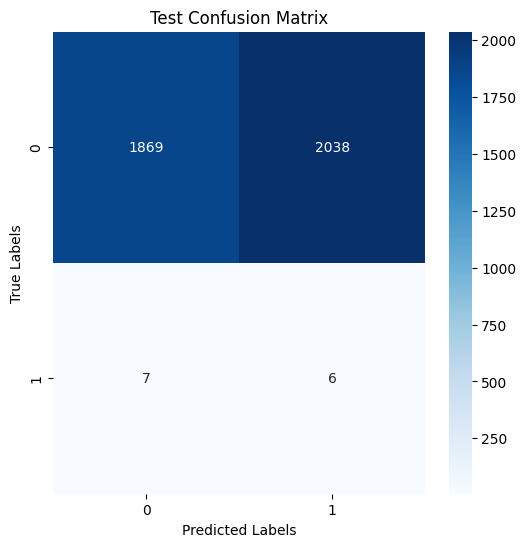

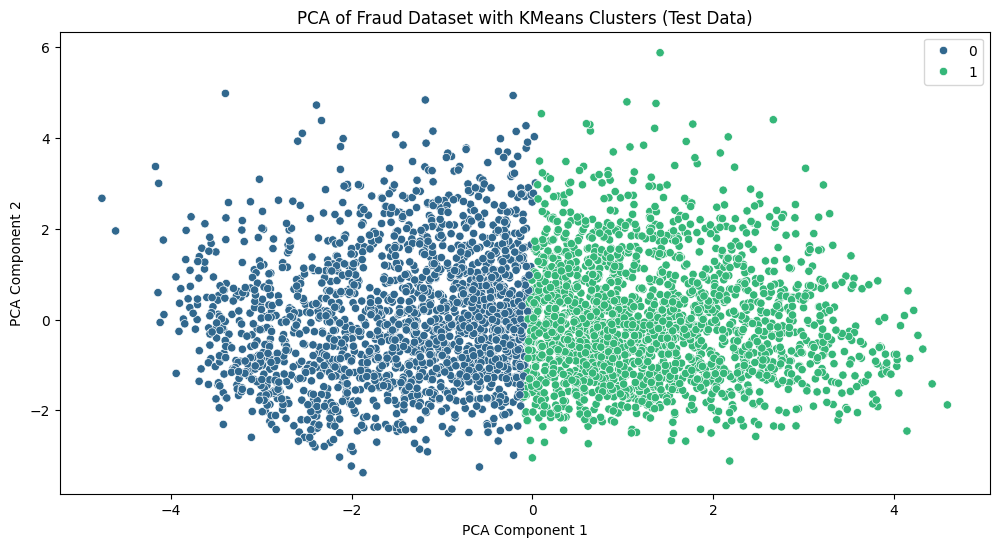

In [312]:
# perform k means clustering
kmeans, X_test_pca_k = kmeans_cluster(train_input, test_input, 2)

#evaluate cluster on test
evaluate_cluster(kmeans, X_test_pca_k, test_output)


Training Silhouette Score: 0.3520947358266475
Test Silhouette Score: 0.3525347228058196
Test accuracy score: 0.8130774697938877
Test Confusion Matrix:
[[3197  696]
 [ 619 2523]]

Test Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.82      0.83      3893
           1       0.78      0.80      0.79      3142

    accuracy                           0.81      7035
   macro avg       0.81      0.81      0.81      7035
weighted avg       0.81      0.81      0.81      7035



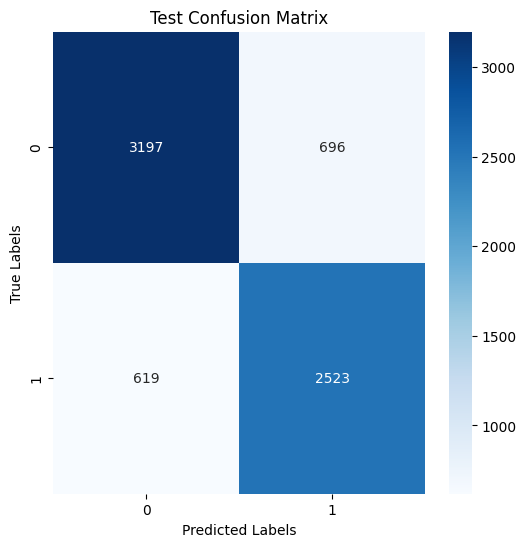

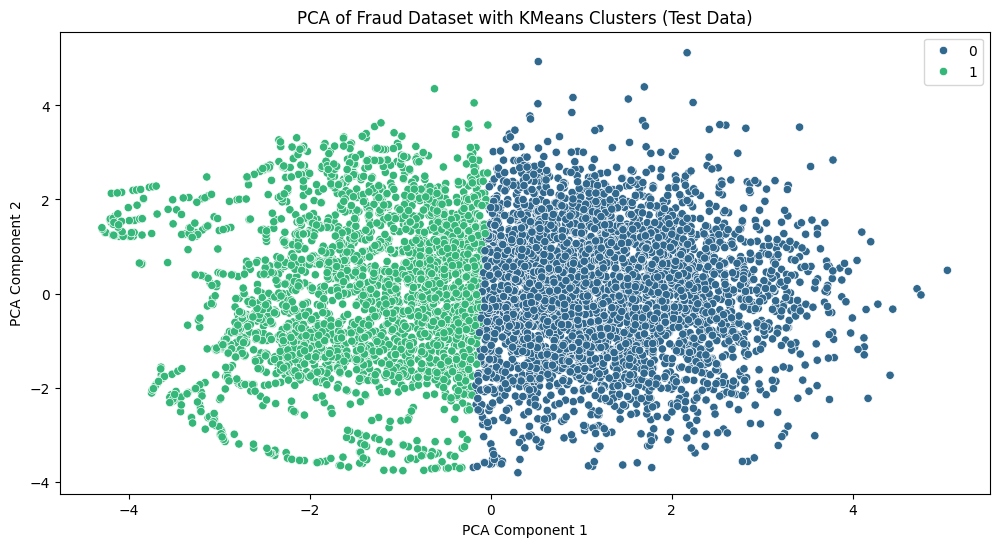

In [314]:
# perform k means clustering
kmeans, X_test_pca_kt = kmeans_cluster(Xtrain, Xtest, 2)

#evaluate cluster on test
evaluate_cluster(kmeans, X_test_pca_kt, ytest)


#### *KMeans clustering with base data*

In [ ]:

# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(train_input)
X_test_scaled = scaler.transform(test_input)

# Apply PCA for dimensionality reduction (for visualization purposes)
pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

# Apply KMeans clustering
kmeans = KMeans(n_clusters=2, random_state=42)
clusters_train = kmeans.fit_predict(X_train_pca)
clusters_test = kmeans.predict(X_test_pca)

# Map clusters to the actual labels (this might need adjustment)
# Assuming cluster 0 is legitimate and cluster 1 is fraud
labels_train = np.zeros_like(clusters_train)
labels_train[clusters_train == 1] = 1

labels_test = np.zeros_like(clusters_test)
labels_test[clusters_test == 1] = 1

# Evaluate with confusion matrix and classification report on training data
cm_train = confusion_matrix(train_output, labels_train)
cr_train = classification_report(train_output, labels_train)
accuracy_train = accuracy_score(train_output, labels_train)


print(f'Train accuracy score: {accuracy_train}')
print('Training Confusion Matrix:')
print(cm_train)
print('\nTraining Classification Report:')
print(cr_train)

# Evaluate with confusion matrix and classification report on test data
cm_test = confusion_matrix(test_output, labels_test)
cr_test = classification_report(test_output, labels_test)
accuracy_test = accuracy_score(test_output, labels_test)

print(f'Test accuracy score: {accuracy_test}')
print('Test Confusion Matrix:')
print(cm_test)
print('\nTest Classification Report:')
print(cr_test)

# Plot confusion matrix for test data
plt.figure(figsize=(6, 6))
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues')
plt.title('Test Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Train accuracy score: 0.4766522071957132
Training Confusion Matrix:
[[7451 8183]
 [  21   21]]

Training Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.48      0.64     15634
           1       0.00      0.50      0.01        42

    accuracy                           0.48     15676
   macro avg       0.50      0.49      0.33     15676
weighted avg       0.99      0.48      0.64     15676

Test accuracy score: 0.4778061224489796
Test Confusion Matrix:
[[1870 2036]
 [  11    3]]

Test Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.48      0.65      3906
           1       0.00      0.21      0.00        14

    accuracy                           0.48      3920
   macro avg       0.50      0.35      0.32      3920
weighted avg       0.99      0.48      0.64      3920



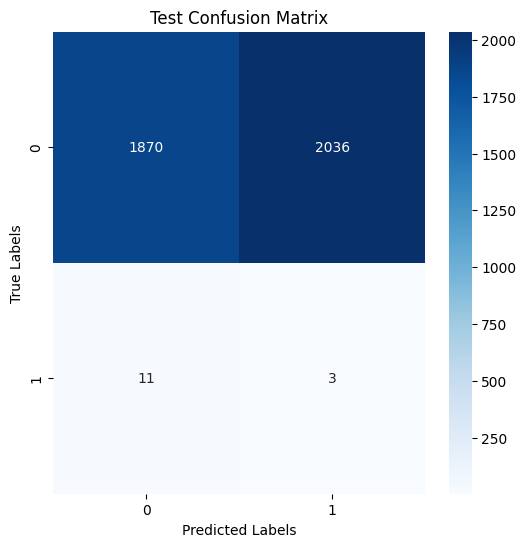

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(train_input)
X_test_scaled = scaler.transform(test_input)

# Apply PCA for dimensionality reduction (for visualization purposes)
pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

# Define the number of splits for K-Fold
n_splits = 5  # You can change this to the desired number of folds
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

# Apply KMeans clustering
kmeans = KMeans(n_clusters=2, random_state=42)
clusters_train = kmeans.fit_predict(X_train_pca)
clusters_test = kmeans.predict(X_test_pca)

# Map clusters to the actual labels (this might need adjustment)
# Assuming cluster 0 is legitimate and cluster 1 is fraud
labels_train = np.zeros_like(clusters_train)
labels_train[clusters_train == 1] = 1

labels_test = np.zeros_like(clusters_test)
labels_test[clusters_test == 1] = 1

# Evaluate with confusion matrix and classification report on training data
cm_train = confusion_matrix(train_output, labels_train)
cr_train = classification_report(train_output, labels_train)
accuracy_train = accuracy_score(train_output, labels_train)


print(f'Train accuracy score: {accuracy_train}')
print('Training Confusion Matrix:')
print(cm_train)
print('\nTraining Classification Report:')
print(cr_train)

# Evaluate with confusion matrix and classification report on test data
cm_test = confusion_matrix(test_output, labels_test)
cr_test = classification_report(test_output, labels_test)
accuracy_test = accuracy_score(test_output, labels_test)

print(f'Test accuracy score: {accuracy_test}')
print('Test Confusion Matrix:')
print(cm_test)
print('\nTest Classification Report:')
print(cr_test)

# Plot confusion matrix for test data
plt.figure(figsize=(6, 6))
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues')
plt.title('Test Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()


#### *KMeans clsutering with Feature engineered data*

Training Silhouette Score: 0.352368192484514
Test Silhouette Score: 0.3462357035817121
Train accuracy score: 0.17453886341827488
Training Confusion Matrix:
[[ 2696 12964]
 [10262  2215]]

Training Classification Report:
              precision    recall  f1-score   support

           0       0.21      0.17      0.19     15660
           1       0.15      0.18      0.16     12477

    accuracy                           0.17     28137
   macro avg       0.18      0.17      0.17     28137
weighted avg       0.18      0.17      0.18     28137

Test accuracy score: 0.17256574271499645
Test Confusion Matrix:
[[ 650 3230]
 [2591  564]]

Test Classification Report:
              precision    recall  f1-score   support

           0       0.20      0.17      0.18      3880
           1       0.15      0.18      0.16      3155

    accuracy                           0.17      7035
   macro avg       0.17      0.17      0.17      7035
weighted avg       0.18      0.17      0.17      7035



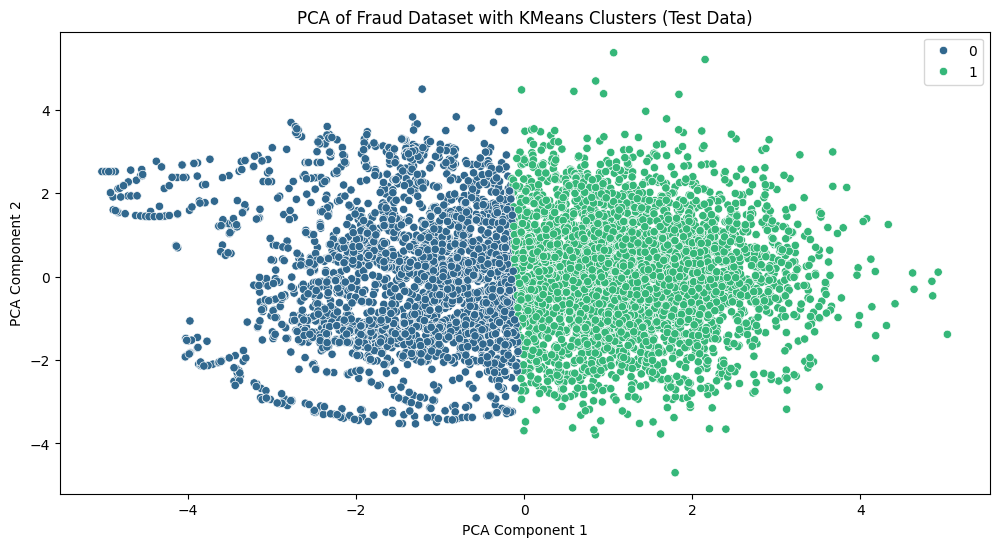

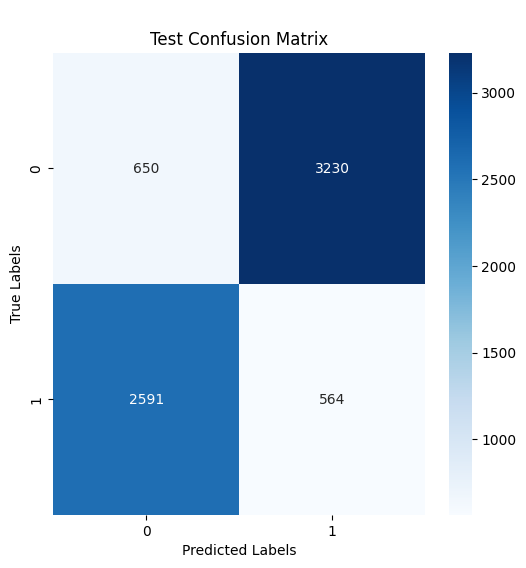

In [303]:


# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(Xtrain)
X_test_scaled = scaler.transform(Xtest)

# Apply PCA for dimensionality reduction (for visualization purposes)
pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

# Apply KMeans clustering
kmeans = KMeans(n_clusters=2, random_state=42)
clusters_train = kmeans.fit_predict(X_train_pca)
clusters_test = kmeans.predict(X_test_pca)

# Evaluate clustering performance on training data
sil_score_train = silhouette_score(X_train_pca, clusters_train)
print(f'Training Silhouette Score: {sil_score_train}')

# Evaluate clustering performance on test data
sil_score_test = silhouette_score(X_test_pca, clusters_test)
print(f'Test Silhouette Score: {sil_score_test}')

# Map clusters to the actual labels (this might need adjustment)
# Assuming cluster 0 is legitimate and cluster 1 is fraud
labels_train = np.zeros_like(clusters_train)
labels_train[clusters_train == 1] = 1

labels_test = np.zeros_like(clusters_test)
labels_test[clusters_test == 1] = 1

# Evaluate with confusion matrix and classification report on training data
cm_train = confusion_matrix(ytrain, labels_train)
cr_train = classification_report(ytrain, labels_train)
accuracy_train = accuracy_score(ytrain, labels_train)


print(f'Train accuracy score: {accuracy_train}')
print('Training Confusion Matrix:')
print(cm_train)
print('\nTraining Classification Report:')
print(cr_train)

# Evaluate with confusion matrix and classification report on test data
cm_test = confusion_matrix(ytest, labels_test)
cr_test = classification_report(ytest, labels_test)
accuracy_test = accuracy_score(ytest, labels_test)

print(f'Test accuracy score: {accuracy_test}')

print('Test Confusion Matrix:')
print(cm_test)
print('\nTest Classification Report:')
print(cr_test)



# Plot PCA results with clusters for test data
plt.figure(figsize=(12, 6))
sns.scatterplot(x=X_test_pca[:, 0], y=X_test_pca[:, 1], hue=clusters_test, palette='viridis', legend='full')
plt.title('PCA of Fraud Dataset with KMeans Clusters (Test Data)')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.show()


# Plot confusion matrix for test data
print('\n\n')
plt.figure(figsize=(6, 6))
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues')
plt.title('\nTest Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()


## Anomaly Detection

In [292]:
# Define the parameter grid for Local Outlier factor
param_grid_lof = {
    'n_neighbors': [10, 20, 30],
    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
    'leaf_size': [20, 30, 40],
    'metric': ['euclidean', 'manhattan', 'minkowski'],
    'p': [1,2],
    'contamination': [0.05, 0.1]
}


# Define parameter grid for Isolation Forest
param_grid_if = {
    'n_estimators': [50, 100, 200],
    'max_samples': ['auto', 0.5, 0.75, 1.0],
    'contamination': [0.01, 0.05, 0.1, 0.2],
    'max_features': [1.0, 0.5, 0.75],
    'bootstrap': [False, True]
}

# Define parameter grid for OneClassSVM
param_grid_svm = {
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    'degree': [2, 3, 4],
    'gamma': ['scale', 'auto', 0.1, 0.01, 0.001],
    'nu': [0.01, 0.05, 0.1, 0.5]
}

# Custom scoring function
def custom_scorer(y_true, y_pred):
    y_pred = np.where(y_pred == 1, 0, 1)
    return accuracy_score(y_true, y_pred)

# Make scorer
scorer = make_scorer(custom_scorer)

# method to display evaluation metrics
def displayReport(clf_name, y, y_pred):
    # Adjust y_pred to match binary classification format
    y_pred[y_pred == 1] = 0
    y_pred[y_pred == -1] = 1
    n_errors = (y_pred != y).sum()
    print(f"{clf_name}: {n_errors}")
    print("Accuracy Score :")
    print(accuracy_score(y, y_pred))
    print('Classification Report: ')
    print(classification_report(y, y_pred))

### Local Outlier Factor

#### *Local outlier Factor with raw data*

In [315]:
def train_lof(X, y, test_X, test_y):
  warnings.filterwarnings('ignore')
  # Initialize the model
  lof = LocalOutlierFactor(novelty=True)
  # Standardize the features
  scaler = StandardScaler()
  X_scaled = scaler.fit_transform(X)
  X_test_scaled = scaler.transform(test_X)

  # Apply PCA for dimensionality reduction (for visualization purposes)
  pca = PCA(n_components=2)
  X_pca = pca.fit_transform(X_scaled)
  X_test_pca = pca.transform(X_test_scaled)

  # Perform Grid Search
  grid_search = GridSearchCV(estimator=lof, param_grid=param_grid_lof, scoring=scorer, cv=5, n_jobs=-1)

  # Fit the model
  grid_search.fit(X_pca)

  # Get the best parameters and best score
  best_params = grid_search.best_params_
  best_score = grid_search.best_score_

  print(f"Best Parameters: {best_params}")
  #print(f"Best Score: {best_score}")

  # Train the final model with best parameters
  best_lof = LocalOutlierFactor(**best_params)
  y_pred = best_lof.fit_predict(X_test_pca)
  displayReport('Local Outlier', test_y, y_pred)

In [316]:
train_lof(train_input, train_output, test_input, test_output)

Best Parameters: {'algorithm': 'auto', 'contamination': 0.05, 'leaf_size': 20, 'metric': 'euclidean', 'n_neighbors': 10, 'p': 1}
Local Outlier: 207
Accuracy Score :
0.9471938775510204
Classification Report: 
              precision    recall  f1-score   support

           0       1.00      0.95      0.97      3907
           1       0.01      0.08      0.01        13

    accuracy                           0.95      3920
   macro avg       0.50      0.51      0.49      3920
weighted avg       0.99      0.95      0.97      3920



In [317]:
train_lof(Xtrain, ytrain, Xtest, ytest)

Best Parameters: {'algorithm': 'auto', 'contamination': 0.05, 'leaf_size': 20, 'metric': 'euclidean', 'n_neighbors': 10, 'p': 1}
Local Outlier: 3124
Accuracy Score :
0.5559346126510306
Classification Report: 
              precision    recall  f1-score   support

           0       0.56      0.96      0.70      3893
           1       0.53      0.06      0.11      3142

    accuracy                           0.56      7035
   macro avg       0.54      0.51      0.41      7035
weighted avg       0.54      0.56      0.44      7035



#### LOF old

In [ ]:
warnings.filterwarnings('ignore')
# Initialize the model
lof = LocalOutlierFactor(novelty=True)
# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_test_scaled = scaler.transform(test_X)

# Apply PCA for dimensionality reduction (for visualization purposes)
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)
X_test_pca = pca.transform(X_test_scaled)

# Perform Grid Search
grid_search = GridSearchCV(estimator=lof, param_grid=param_grid_lof, scoring=scorer, cv=5, n_jobs=-1)

# Fit the model
grid_search.fit(train_input)

# Get the best parameters and best score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print(f"Best Parameters: {best_params}")
#print(f"Best Score: {best_score}")

# Train the final model with best parameters
best_lof = LocalOutlierFactor(**best_params)
y_pred = best_lof.fit_predict(test_input)
displayReport('Local Outlier', test_output, y_pred)

Best Parameters: {'algorithm': 'auto', 'contamination': 0.05, 'leaf_size': 20, 'metric': 'euclidean', 'n_neighbors': 10, 'p': 1}
Local Outlier: 209
Accuracy Score :
0.9466836734693878
Classification Report: 
              precision    recall  f1-score   support

           0       1.00      0.95      0.97      3905
           1       0.01      0.07      0.01        15

    accuracy                           0.95      3920
   macro avg       0.50      0.51      0.49      3920
weighted avg       0.99      0.95      0.97      3920



### Isolation Forest

In [322]:
def train_isolationForest(X, y, test_X, test_y):
  # Initialize the model
  clf_if = IsolationForest(random_state=42, verbose=0)

  # Standardize the features
  scaler = StandardScaler()
  X_scaled = scaler.fit_transform(X)
  X_test_scaled = scaler.transform(test_X)

  # Apply PCA for dimensionality reduction (for visualization purposes)
  pca = PCA(n_components=2)
  X_pca = pca.fit_transform(X_scaled)
  X_test_pca = pca.transform(X_test_scaled)

  grid_search_if = GridSearchCV(estimator=clf_if, param_grid=param_grid_if, scoring=scorer, cv=5, n_jobs=-1)
  grid_search_if.fit(X_pca, y)


  # Get the best parameters and best score
  best_params_if = grid_search_if.best_params_
  best_score_if = grid_search_if.best_score_

  print(f"Best Parameters: {best_params_if}")
  print(f"Best Score: {best_score_if}")

  # Train the final Isolation Forest model with best parameters
  best_isolation_forest = IsolationForest(**best_params_if, random_state=42)
  y_pred_if = best_isolation_forest.fit_predict(X_test_pca)
  displayReport('Isolation Forest',test_y, y_pred_if)

In [323]:
train_isolationForest(train_input, train_output, test_input, test_output)

Best Parameters: {'bootstrap': True, 'contamination': 0.01, 'max_features': 0.5, 'max_samples': 'auto', 'n_estimators': 200}
Best Score: 0.9879435398561338
Isolation Forest: 51
Accuracy Score :
0.9869897959183673
Classification Report: 
              precision    recall  f1-score   support

           0       1.00      0.99      0.99      3907
           1       0.03      0.08      0.04        13

    accuracy                           0.99      3920
   macro avg       0.51      0.53      0.52      3920
weighted avg       0.99      0.99      0.99      3920



In [324]:
train_isolationForest(Xtrain, ytrain, Xtest, ytest)

Best Parameters: {'bootstrap': True, 'contamination': 0.05, 'max_features': 0.5, 'max_samples': 'auto', 'n_estimators': 50}
Best Score: 0.5744747599179456
Isolation Forest: 3018
Accuracy Score :
0.571002132196162
Classification Report: 
              precision    recall  f1-score   support

           0       0.57      0.97      0.71      3893
           1       0.68      0.08      0.14      3142

    accuracy                           0.57      7035
   macro avg       0.62      0.52      0.43      7035
weighted avg       0.61      0.57      0.46      7035



### Isolation Forest Old

In [ ]:
# Initialize the model
clf_if = IsolationForest(random_state=42, verbose=0)

#Reduce the dimensions
train_input = dim_features(train_input)
test_input = dim_features(test_input)

grid_search_if = GridSearchCV(estimator=clf_if, param_grid=param_grid_if, scoring=scorer, cv=5, n_jobs=-1)
grid_search_if.fit(train_input, train_output)


# Get the best parameters and best score
best_params_if = grid_search_if.best_params_
best_score_if = grid_search_if.best_score_

print(f"Best Parameters: {best_params}")
print(f"Best Score: {best_score}")

# Train the final Isolation Forest model with best parameters
best_isolation_forest = IsolationForest(**best_params_if, random_state=42)
y_pred_if = best_isolation_forest.fit_predict(test_input)
displayReport('Isolation Forest',test_output, y_pred_if)

Best Parameters: {'algorithm': 'auto', 'contamination': 0.05, 'leaf_size': 20, 'metric': 'euclidean', 'n_neighbors': 10, 'p': 1}
Best Score: nan
Isolation Forest: 45
Accuracy Score :
0.9885204081632653
Classification Report: 
              precision    recall  f1-score   support

           0       1.00      0.99      0.99      3915
           1       0.00      0.00      0.00         5

    accuracy                           0.99      3920
   macro avg       0.50      0.49      0.50      3920
weighted avg       1.00      0.99      0.99      3920



In [ ]:
# Initialize the model
clf_if = IsolationForest(random_state=42, verbose=0)

#Reduce the dimensions
train_input = dim_features(Xtrain)
test_input = dim_features(Xtest)

grid_search_if = GridSearchCV(estimator=clf_if, param_grid=param_grid_if, scoring=scorer, cv=5, n_jobs=-1)
grid_search_if.fit(train_input, ytrain)


# Get the best parameters and best score
best_params_if = grid_search_if.best_params_
best_score_if = grid_search_if.best_score_

print(f"Best Parameters: {best_params}")
print(f"Best Score: {best_score}")

# Train the final Isolation Forest model with best parameters
best_isolation_forest = IsolationForest(**best_params_if, random_state=42)
y_pred_if = best_isolation_forest.fit_predict(test_input)
displayReport('Isolation Forest',ytest, y_pred_if)

Best Parameters: {'algorithm': 'auto', 'contamination': 0.05, 'leaf_size': 20, 'metric': 'euclidean', 'n_neighbors': 10, 'p': 1}
Best Score: nan
Isolation Forest: 3138
Accuracy Score :
0.5539445628997868
Classification Report: 
              precision    recall  f1-score   support

           0       0.57      0.82      0.67      3928
           1       0.49      0.22      0.30      3107

    accuracy                           0.55      7035
   macro avg       0.53      0.52      0.49      7035
weighted avg       0.53      0.55      0.51      7035



#### One class SVM

In [325]:
def train_OCSVM(X, y, test_X, test_y):
  # Initialize the model
  one_class_svm = OneClassSVM(max_iter=-1)

  # Standardize the features
  scaler = StandardScaler()
  X_scaled = scaler.fit_transform(X)
  X_test_scaled = scaler.transform(test_X)

  # Apply PCA for dimensionality reduction (for visualization purposes)
  pca = PCA(n_components=2)
  X_pca = pca.fit_transform(X_scaled)
  X_test_pca = pca.transform(X_test_scaled)

  # Perform Grid Search for OneClassSVM
  grid_search_svm = GridSearchCV(estimator=one_class_svm, param_grid=param_grid_svm, scoring=scorer, cv=5, n_jobs=-1)
  grid_search_svm.fit(X_pca, y)
  best_params_svm = grid_search_svm.best_params_
  best_score_svm = grid_search_svm.best_score_
  warnings.filterwarnings('ignore')

  print(f"Best Parameters for OneClassSVM: {best_params_svm}")
  print(f"Best Score for OneClassSVM: {best_score_svm}")

  # Train the final OneClassSVM model with best parameters
  best_one_class_svm = OneClassSVM(**best_params_svm, max_iter=-1)
  y_pred_svm = best_one_class_svm.fit_predict(X_test_pca)
  displayReport('One class SVM',test_y, y_pred_svm)

In [326]:
train_OCSVM(train_input, train_output, test_input, test_output)

Best Parameters for OneClassSVM: {'degree': 4, 'gamma': 'auto', 'kernel': 'poly', 'nu': 0.01}
Best Score for OneClassSVM: 0.9876882343846629
One class SVM: 81
Accuracy Score :
0.9793367346938775
Classification Report: 
              precision    recall  f1-score   support

           0       1.00      0.98      0.99      3907
           1       0.00      0.00      0.00        13

    accuracy                           0.98      3920
   macro avg       0.50      0.49      0.49      3920
weighted avg       0.99      0.98      0.99      3920



In [327]:
train_OCSVM(Xtrain, ytrain, Xtest, ytest)

Best Parameters for OneClassSVM: {'degree': 2, 'gamma': 'scale', 'kernel': 'linear', 'nu': 0.5}
Best Score for OneClassSVM: 0.6239795652219493
One class SVM: 1527
Accuracy Score :
0.7829424307036247
Classification Report: 
              precision    recall  f1-score   support

           0       0.83      0.77      0.80      3893
           1       0.74      0.80      0.77      3142

    accuracy                           0.78      7035
   macro avg       0.78      0.78      0.78      7035
weighted avg       0.79      0.78      0.78      7035



#### One class SVM old

In [ ]:
#Reduce the dimensions
train_input = dim_features(Xtrain)
test_input = dim_features(Xtest)


one_class_svm = OneClassSVM(max_iter=-1)

# Perform Grid Search for OneClassSVM
grid_search_svm = GridSearchCV(estimator=one_class_svm, param_grid=param_grid_svm, scoring=scorer, cv=5, n_jobs=-1)
grid_search_svm.fit(train_input, ytrain)
best_params_svm = grid_search_svm.best_params_
best_score_svm = grid_search_svm.best_score_
warnings.filterwarnings('ignore')

print(f"Best Parameters for OneClassSVM: {best_params_svm}")
print(f"Best Score for OneClassSVM: {best_score_svm}")

# Train the final OneClassSVM model with best parameters
best_one_class_svm = OneClassSVM(**best_params_svm, max_iter=-1)
y_pred_svm = best_one_class_svm.fit_predict(test_input)
displayReport('One class SVM',ytest, y_pred_svm)

Best Parameters for OneClassSVM: {'degree': 2, 'gamma': 'scale', 'kernel': 'linear', 'nu': 0.5}
Best Score for OneClassSVM: 0.5985108350956381
One class SVM: 5357
Accuracy Score :
0.23852167732764748
Classification Report: 
              precision    recall  f1-score   support

           0       0.30      0.28      0.29      3894
           1       0.17      0.18      0.18      3141

    accuracy                           0.24      7035
   macro avg       0.24      0.23      0.23      7035
weighted avg       0.24      0.24      0.24      7035



In [ ]:
#Reduce the dimensions
train_input = dim_features(Xtrain)
test_input = dim_features(Xtest)


one_class_svm = OneClassSVM(max_iter=-1)

# Perform Grid Search for OneClassSVM
grid_search_svm = GridSearchCV(estimator=one_class_svm, param_grid=param_grid_svm, scoring=scorer, cv=5, n_jobs=-1)
grid_search_svm.fit(train_input, ytrain)
best_params_svm = grid_search_svm.best_params_
best_score_svm = grid_search_svm.best_score_
warnings.filterwarnings('ignore')

print(f"Best Parameters for OneClassSVM: {best_params_svm}")
print(f"Best Score for OneClassSVM: {best_score_svm}")

# Train the final OneClassSVM model with best parameters
best_one_class_svm = OneClassSVM(**best_params_svm, max_iter=-1)
y_pred_svm = best_one_class_svm.fit_predict(test_input)
displayReport('One class SVM',ytest, y_pred_svm)

Best Parameters for OneClassSVM: {'degree': 2, 'gamma': 0.01, 'kernel': 'poly', 'nu': 0.01}
Best Score for OneClassSVM: 0.5673667383714094
One class SVM: 3346
Accuracy Score :
0.5243781094527363
Classification Report: 
              precision    recall  f1-score   support

           0       0.57      0.58      0.58      3894
           1       0.47      0.45      0.46      3141

    accuracy                           0.52      7035
   macro avg       0.52      0.52      0.52      7035
weighted avg       0.52      0.52      0.52      7035



## Classfication Algorithms

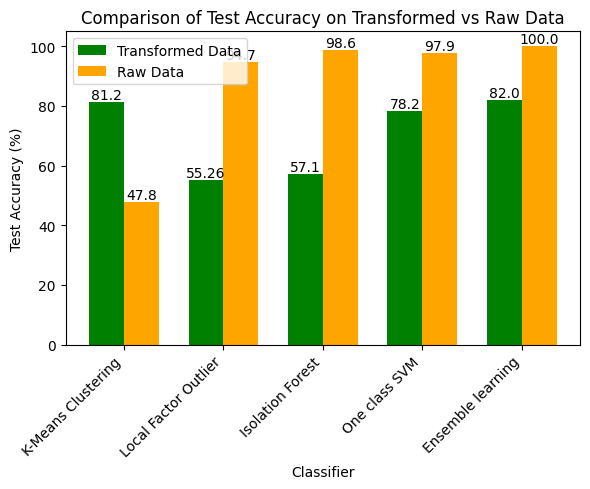

In [399]:

# Step 1: Organize the data into a pandas DataFrame
data = {
    "Classifier": [
        "K-Means Clustering", "Local Factor Outlier", "Isolation Forest", "One class SVM",
        "Ensemble learning"
    ],
    "Test Accuracy Transformed": [81.2, 55.26, 57.1, 78.2, 82],
    "Test Accuracy Raw": [47.8, 94.7, 98.6, 97.9, 100]
}

df = pd.DataFrame(data)

# Step 2: Create the grouped bar plot
fig, ax = plt.subplots(figsize=(6, 5))

# Define the width of the bars
bar_width = 0.35

# Set the positions of the bars on the x-axis
index = np.arange(len(df['Classifier']))

# Plot bars for transformed and raw data test accuracies
transformed_bars = ax.bar(index, df['Test Accuracy Transformed'], bar_width, label='Transformed Data', color='green')
raw_bars = ax.bar(index + bar_width, df['Test Accuracy Raw'], bar_width, label='Raw Data', color='orange')

for bar in transformed_bars:
    yval = bar.get_height()
    ax.text(bar.get_x() + bar.get_width() / 2, yval, round(yval, 2), ha='center', va='bottom', fontsize=10)

for bar in raw_bars:
    yval = bar.get_height()
    ax.text(bar.get_x() + bar.get_width() / 2, yval, round(yval, 2), ha='center', va='bottom', fontsize=10)


# Adding labels, title, and custom x-axis tick labels, etc.
ax.set_xlabel('Classifier')
ax.set_ylabel('Test Accuracy (%)')
ax.set_title('Comparison of Test Accuracy on Transformed vs Raw Data')
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(df['Classifier'], rotation=45, ha="right")
ax.legend()

# Show plot
plt.tight_layout()
plt.show()


In [400]:
precision_raw = [0, 0.01, 0.03, 0, 0]
recall_raw = [0.46, 0.08, .08, 0, 0]
precision_transformed = [0.78, 0.53, 0.68, 0.74, 0.74]
recall_transformed = [0.80, 0.06, 0.08, 0.80, 0.80]

In [402]:


# Step 1: Organize the data into a pandas DataFrame
precision_raw = [0, 0.01, 0.03, 0, 0]
recall_raw = [0.46, 0.08, .08, 0, 0]
precision_transformed = [0.78, 0.53, 0.68, 0.74, 0.74]
recall_transformed = [0.80, 0.06, 0.08, 0.80, 0.80]

data = {
    "Classifier": [
        "K-Means Clustering", "Local Factor Outlier", "Isolation Forest", "One class SVM",
        "Ensemble Learning"
    ],
    "Class": [1] * 5,
    "Precision Raw": precision_raw,
    "Precision Transformed": precision_transformed,
    "Recall Raw": recall_raw,
    "Recall Transformed": recall_transformed
}

df = pd.DataFrame(data)

df

Classifier  Class  Precision Raw  Precision Transformed  \
0    K-Means Clustering      1           0.00                   0.78   
1  Local Factor Outlier      1           0.01                   0.53   
2      Isolation Forest      1           0.03                   0.68   
3         One class SVM      1           0.00                   0.74   
4     Ensemble Learning      1           0.00                   0.74   

   Recall Raw  Recall Transformed  
0        0.46                0.80  
1        0.08                0.06  
2        0.08                0.08  
3        0.00                0.80  
4        0.00                0.80

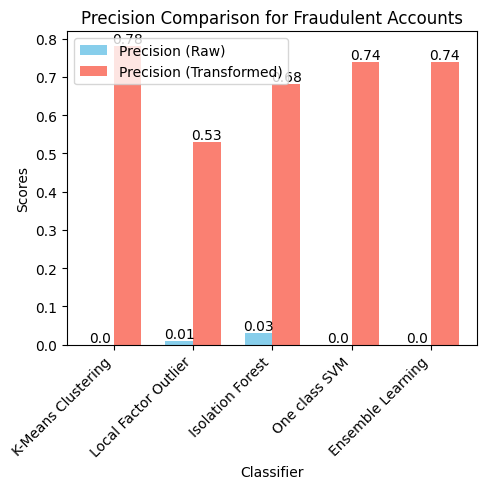

In [404]:
# Filter the DataFrame for the fraudulent class (Class == 0)
df_fraudulent = df[df['Class'] == 1]

# Step 2: Create the grouped bar plot
fig, ax = plt.subplots(figsize=(5, 5))

# Define the width of the bars
bar_width = 0.35

# Set the positions of the bars on the x-axis
index = np.arange(len(df_fraudulent))

# Plot bars for Precision and Recall
precision_bars = ax.bar(index, df_fraudulent['Precision Raw'], bar_width, label='Precision (Raw)', color='skyblue')
recall_bars = ax.bar(index + bar_width, df_fraudulent['Precision Transformed'], bar_width, label='Precision (Transformed)', color='salmon')

for bar in precision_bars:
    yval = bar.get_height()
    ax.text(bar.get_x() + bar.get_width() / 2, yval, round(yval, 2), ha='center', va='bottom', fontsize=10)

for bar in recall_bars:
    yval = bar.get_height()
    ax.text(bar.get_x() + bar.get_width() / 2, yval, round(yval, 2), ha='center', va='bottom', fontsize=10)


# Adding labels, title, and custom x-axis tick labels, etc.
ax.set_xlabel('Classifier')
ax.set_ylabel('Scores')
ax.set_title('Precision Comparison for Fraudulent Accounts')
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(df_fraudulent['Classifier'], rotation=45, ha="right")
ax.legend()

# Show plot
plt.tight_layout()
plt.show()

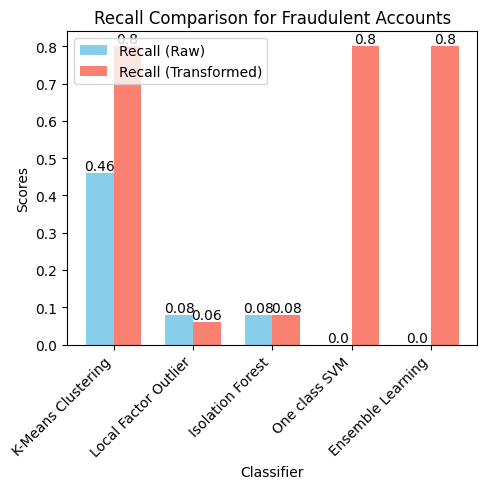

In [405]:
# Filter the DataFrame for the fraudulent class (Class == 0)
df_fraudulent = df[df['Class'] == 1]

# Step 2: Create the grouped bar plot
fig, ax = plt.subplots(figsize=(5, 5))

# Define the width of the bars
bar_width = 0.35

# Set the positions of the bars on the x-axis
index = np.arange(len(df_fraudulent))

# Plot bars for Precision and Recall
precision_bars = ax.bar(index, df_fraudulent['Recall Raw'], bar_width, label='Recall (Raw)', color='skyblue')
recall_bars = ax.bar(index + bar_width, df_fraudulent['Recall Transformed'], bar_width, label='Recall (Transformed)', color='salmon')

for bar in precision_bars:
    yval = bar.get_height()
    ax.text(bar.get_x() + bar.get_width() / 2, yval, round(yval, 2), ha='center', va='bottom', fontsize=10)

for bar in recall_bars:
    yval = bar.get_height()
    ax.text(bar.get_x() + bar.get_width() / 2, yval, round(yval, 2), ha='center', va='bottom', fontsize=10)


# Adding labels, title, and custom x-axis tick labels, etc.
ax.set_xlabel('Classifier')
ax.set_ylabel('Scores')
ax.set_title('Recall Comparison for Fraudulent Accounts')
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(df_fraudulent['Classifier'], rotation=45, ha="right")
ax.legend()

# Show plot
plt.tight_layout()
plt.show()

In [406]:
def precision_recall_plot(raw, transformed, plot):
  data = {
    "Classifier": [
        "Local Factor Outlier", "Isolation Forest", "One class SVM"
    ],
    "Class": [1] * 3,
    "Raw": raw,
    "Transformed": transformed
  }

  df_fraudulent = pd.DataFrame(data)

  # Step 2: Create the grouped bar plot
  fig, ax = plt.subplots(figsize=(5, 5))

  # Define the width of the bars
  bar_width = 0.35

  # Set the positions of the bars on the x-axis
  index = np.arange(len(df_fraudulent))

  # Plot bars for Precision and Recall
  precision_bars = ax.bar(index, df_fraudulent['Raw'], bar_width, label=f'{plot} (Raw)', color='skyblue')
  recall_bars = ax.bar(index + bar_width, df_fraudulent['Transformed'], bar_width, label=f'{plot} (Transformed)', color='salmon')

  for bar in precision_bars:
      yval = bar.get_height()
      ax.text(bar.get_x() + bar.get_width() / 2, yval, round(yval, 2), ha='center', va='bottom', fontsize=10)

  for bar in recall_bars:
      yval = bar.get_height()
      ax.text(bar.get_x() + bar.get_width() / 2, yval, round(yval, 2), ha='center', va='bottom', fontsize=10)

  # Adding labels, title, and custom x-axis tick labels, etc.
  ax.set_xlabel('Classifier')
  ax.set_ylabel('Scores')
  ax.set_title(f'{plot} Comparison for Fraudulent Accounts')
  ax.set_xticks(index + bar_width / 2)
  ax.set_xticklabels(df_fraudulent['Classifier'], rotation=45, ha="right")
  ax.legend()

  # Show plot
  plt.tight_layout()
  plt.show()

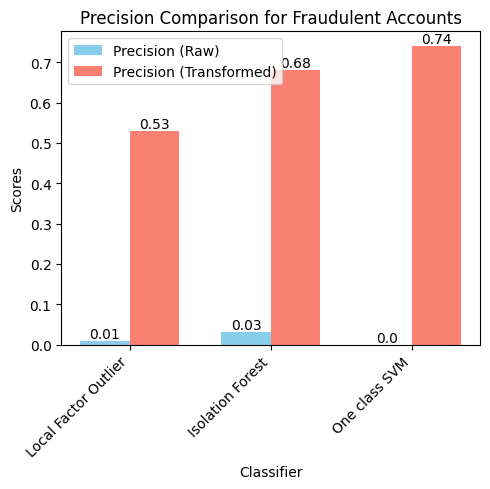

In [407]:
raw = [0.01,0.03, 0]
transformed = [0.53,0.68,0.74]
precision_recall_plot(raw, transformed, 'Precision')

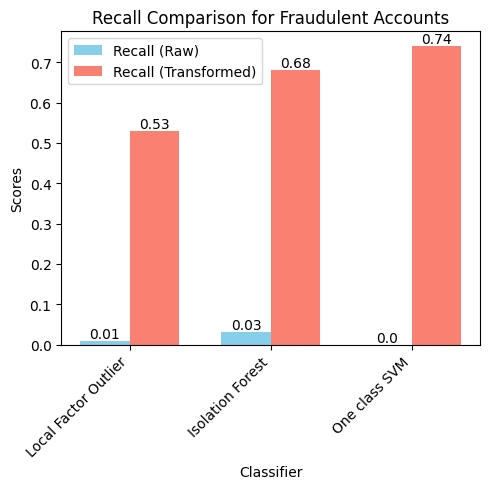

In [408]:
recall_raw = [0.08,0.08,0]
recall_transformed = [0.06, 0.08, 0.80]
precision_recall_plot(raw, transformed, 'Recall')


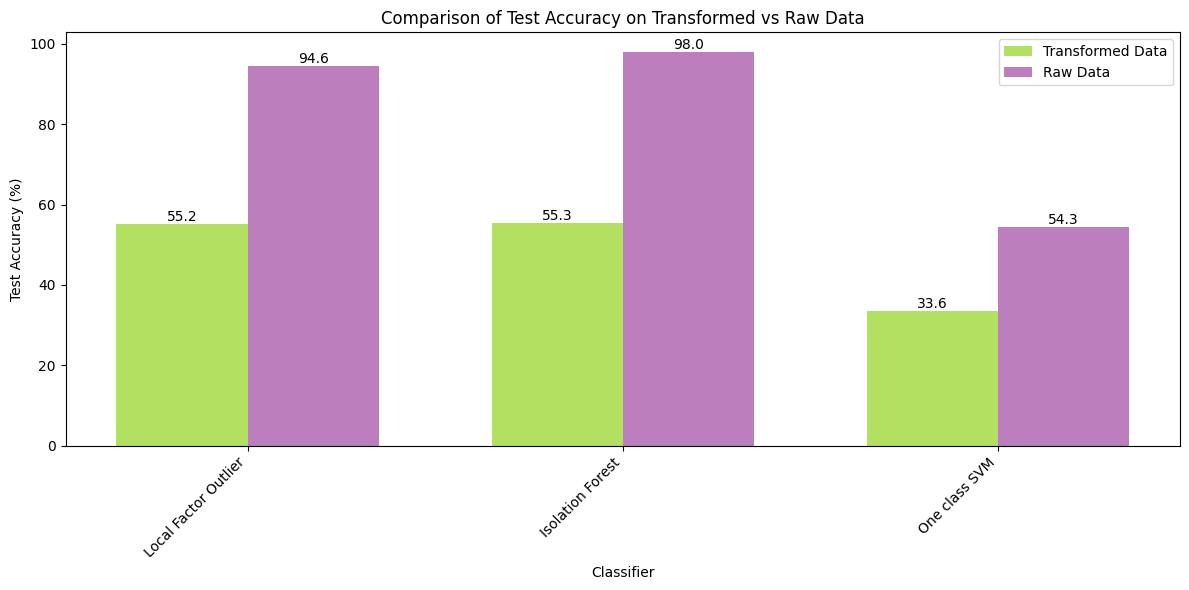

In [414]:

# Step 1: Organize the data into a pandas DataFrame
data = {
    "Classifier": [
        "Local Factor Outlier", "Isolation Forest", "One class SVM"
    ],
    "Test Accuracy Transformed": [55.2, 55.3, 33.6],
    "Test Accuracy Raw": [94.6, 98.0, 54.3]
}

df = pd.DataFrame(data)

# Step 2: Create the grouped bar plot
fig, ax = plt.subplots(figsize=(12, 6))

# Define the width of the bars
bar_width = 0.35

# Set the positions of the bars on the x-axis
index = np.arange(len(df['Classifier']))

# Plot bars for transformed and raw data test accuracies
transformed_bars = ax.bar(index, df['Test Accuracy Transformed'], bar_width, label='Transformed Data', color='#b2e061')
raw_bars = ax.bar(index + bar_width, df['Test Accuracy Raw'], bar_width, label='Raw Data', color='#bd7ebe')


# Adding labels, title, and custom x-axis tick labels, etc.
ax.set_xlabel('Classifier')
ax.set_ylabel('Test Accuracy (%)')
ax.set_title('Comparison of Test Accuracy on Transformed vs Raw Data')
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(df['Classifier'], rotation=45, ha="right")
ax.legend()

for bar in transformed_bars:
    yval = bar.get_height()
    ax.text(bar.get_x() + bar.get_width() / 2, yval, round(yval, 1), ha='center', va='bottom', fontsize=10)

for bar in raw_bars:
    yval = bar.get_height()
    ax.text(bar.get_x() + bar.get_width() / 2, yval, round(yval, 1), ha='center', va='bottom', fontsize=10)


# Show plot
plt.tight_layout()
plt.show()


In [ ]:
def precision_recall_plot(raw, transformed, plot):
  data = {
    "Classifier": [
        "Ensemble Learning"
    ],
    "Class": [1] * 1,
    "Raw": raw,
    "Transformed": transformed
  }

  df_fraudulent = pd.DataFrame(data)

  # Step 2: Create the grouped bar plot
  fig, ax = plt.subplots(figsize=(5, 5))

  # Define the width of the bars
  bar_width = 0.35

  # Set the positions of the bars on the x-axis
  index = np.arange(len(df_fraudulent))

  # Plot bars for Precision and Recall
  precision_bars = ax.bar(index, df_fraudulent['Raw'], bar_width, label=f'{plot} (Raw)', color='skyblue')
  recall_bars = ax.bar(index + bar_width, df_fraudulent['Transformed'], bar_width, label=f'{plot} (Transformed)', color='salmon')

  # Adding labels, title, and custom x-axis tick labels, etc.
  ax.set_xlabel('Classifier')
  ax.set_ylabel('Scores')
  ax.set_title(f'{plot} Comparison for Ensemble Learning')
  ax.set_xticks(index + bar_width / 2)
  ax.set_xticklabels(df_fraudulent['Classifier'], rotation=45, ha="right")
  ax.legend()

  # Show plot
  plt.tight_layout()
  plt.show()

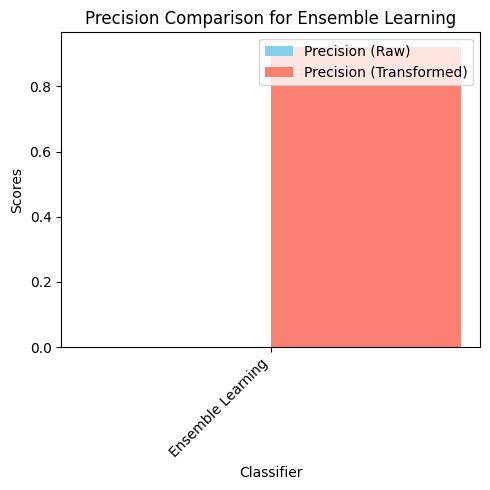

In [ ]:
raw = [0]
transformed = [0.92]
precision_recall_plot(raw, transformed, 'Precision')

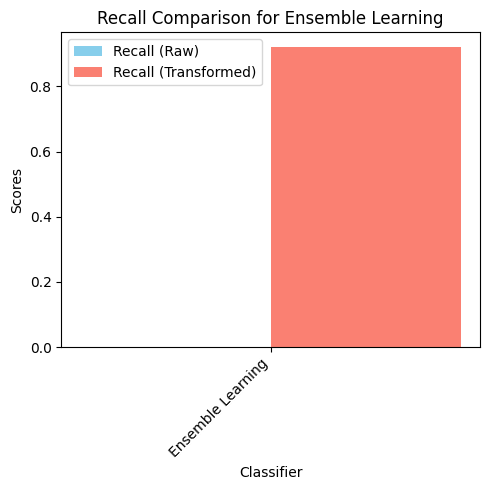

In [ ]:
raw = [0]
transformed = [0.92]
precision_recall_plot(raw, transformed, 'Recall')